In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.patches as patches
import os
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print(os.listdir("../input"))

['stage_2_test_images', 'stage_2_sample_submission.csv', 'stage_2_detailed_class_info.csv', 'stage_2_train_images', 'stage_2_train_labels.csv', 'GCP Credits Request Link - RSNA.txt']


In [7]:
import pydicom # Read, modify and write DICOM files with python code
import matplotlib.pyplot as plt

In [8]:
random_stat = 123
np.random.seed(random_stat)

# Load the dataset

In [9]:
!ls ../input

GCP Credits Request Link - RSNA.txt  stage_2_test_images
stage_2_detailed_class_info.csv      stage_2_train_images
stage_2_sample_submission.csv	     stage_2_train_labels.csv


## Labels

In [10]:
df = pd.read_csv('../input/stage_2_train_labels.csv')
print(df.head(5))
print(f'The total number of trianing examples: {len(df)}')

                              patientId      x   ...    height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN   ...       NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN   ...       NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN   ...       NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN   ...       NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0   ...     379.0       1

[5 rows x 6 columns]
The total number of trianing examples: 30227


1. Positive example: target == 0 (No pneumonia)

In [11]:
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


1. Negative example: target == 1 (has pneumonia)
 * Note: a positive example may have mulitple bboxes

In [12]:
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


## Input data and dimension

In [13]:
patientId = df['patientId'][0]
dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [14]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


### Prepare a small set of data (2000)

In [15]:
NUM_OF_DATA = 2000

In [16]:
print(len(df['patientId']))

30227


In [17]:
df['patientId'][0]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

In [18]:
small_patient_ids = df['patientId'][:NUM_OF_DATA]
training_images = []
training_labels = []
for patient_id in small_patient_ids:
    dcm_file = f'../input/stage_2_train_images/{patient_id}.dcm'
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    training_images.append(im)
    training_labels.append(df[df['patientId']==patient_id].values)
    

### Visualize the training image with boundingbox

[['00436515-870c-4b36-a041-de91049b9ab4' 264.0 152.0 213.0 379.0 1]
 ['00436515-870c-4b36-a041-de91049b9ab4' 562.0 152.0 256.0 453.0 1]]


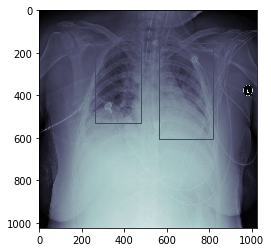

In [19]:
sample_index = 4
im = training_images[sample_index]
fig,ax = plt.subplots(1)
for bbox in range(len(training_labels[sample_index])):
    bx, by, bh, bw = [i for i in training_labels[sample_index][bbox][1:5]]
    # Display the image
    ax.imshow(im, cmap=plt.cm.bone)
    # Create a Rectangle patch
    rect = patches.Rectangle((bx, by), bh, bw ,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
print(training_labels[sample_index])
plt.show()


### Darknet

In [20]:
!git clone https://github.com/pjreddie/darknet

# Build gpu version darknet
!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

Cloning into 'darknet'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.14 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (3945/3945), done.
Checking connectivity... done.


## Training YOLO on RSNA 

### Generate Labels for YOLO3

In [21]:
DATA_DIR = "../input"

train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [22]:
!ls -shtl

total 1.9M
4.0K drwxr-xr-x  2 root root 4.0K Nov  1 23:23 backup
4.0K drwxr-xr-x  2 root root 4.0K Nov  1 23:23 cfg
4.0K drwxr-xr-x  2 root root 4.0K Nov  1 23:23 labels
4.0K drwxr-xr-x  2 root root 4.0K Nov  1 23:23 metadata
4.0K drwxr-xr-x  2 root root 4.0K Nov  1 23:23 images
1.9M -rwxr-xr-x  1 root root 1.9M Nov  1 23:23 darknet_gpu
4.0K drwxr-xr-x 13 root root 4.0K Nov  1 23:23 darknet
4.0K -rw-r--r--  1 root root  199 Nov  1 23:22 __notebook_source__.ipynb


## Generate  .txt file for YOLO3

In [23]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

patientId      x   ...    height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN   ...       NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN   ...       NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN   ...       NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN   ...       NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0   ...     379.0       1

[5 rows x 6 columns]

In [27]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
    
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [28]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 30227/30227 [02:25<00:00, 207.38it/s]


In [29]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [46]:
# Following lines do not contain data with no bbox
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5410, The # of validation set: 602


In [47]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [48]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)


## Modify Cfg for RSNA data

In [49]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [50]:
!cat cfg/rsna.data

classes= 1
train  = /kaggle/working/metadata/tr_list.txt
valid  = /kaggle/working/metadata/val_list.txt
names  = /kaggle/working/cfg/rsna.names
backup = /kaggle/working/backup
    

In [51]:
!echo "pneumonia" > cfg/rsna.names

## Download Pretrained Convolutional Weights

In [52]:
!wget -q https://pjreddie.com/media/files/darknet53.conv.74

## Pre-generated .cfg_train

In [53]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=13huTgMdLhwc3XGF3ucbPXR3MFRk0zgaN" -O cfg/rsna_yolov3.cfg_train

## Training

In [54]:
!./darknet_gpu detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Done!
Learning Rate: 0.001, Momentum: 0.9, Decay: 0.0005
Resizing
544
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561732, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.500261, Class: 0.667751, Obj: 0.275421, No Obj: 0.494920, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415433, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562213, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.212427, Class: 0.736269, Obj: 0.121154, No Obj: 0.495594, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413934, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.359752, Class: 0.387197, Obj: 0.673977, No Obj: 0.564688, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495128, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496440, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415638, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.272525, Class: 0.843213, Obj: 0.598234, No Obj: 0.562762, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494743, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415887, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.107636, Class: 0.569987, Obj: 0.645370, No Obj: 0.563906, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495144, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416241, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.172122, Class: 0.544150, Obj: 0.490290, No Obj: 0.563386, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416430, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.456014, Class: 0.620479, Obj: 0.429373, No Obj: 0.495380, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415391, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562186, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.236880, Class: 0.590717, Obj: 0.489064, No Obj: 0.495535, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415234, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.051122, Class: 0.243493, Obj: 0.338374, No Obj: 0.563094, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495307, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.263373, Class: 0.611353, Obj: 0.432970, No Obj: 0.495108, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417530, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.053558, Class: 0.452297, Obj: 0.614582, No Obj: 0.561606, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.419824, .5R: -nan, .75R: -nan,  count: 0
2: 1397.202393, 1397.734375 avg, 0.000000 rate, 22.385940 seconds, 128 images
Loaded: 0.000062 seconds
Region 82 Avg IOU: 0.099290, Class: 0.889134, Obj: 0.554624, No Obj: 0.564305, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.320819, Class: 0.597519, Obj: 0.691322, No Obj: 0.495529, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417373, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg 

Region 94 Avg IOU: 0.532381, Class: 0.697477, Obj: 0.143722, No Obj: 0.492349, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416630, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565069, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.301805, Class: 0.504286, Obj: 0.103086, No Obj: 0.494501, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416140, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.040292, Class: 0.745171, Obj: 0.314233, No Obj: 0.563793, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495868, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415717, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.059001, Class: 0.374254, Obj: 0.416759, No Obj: 0.561233, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495578, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412594, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562902, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.440752, Class: 0.310814, Obj: 0.394165, No Obj: 0.494330, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412699, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.330416, Class: 0.739987, Obj: 0.474472, No Obj: 0.561428, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.535089, Class: 0.580214, Obj: 0.307243, No Obj: 0.495074, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415691, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.800301, Class: 0.815094, Obj: 0.589800, No Obj: 0.560318, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561641, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.454412, Class: 0.777819, Obj: 0.206169, No Obj: 0.492343, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413295, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.266000, Class: 0.658312, Obj: 0.658989, No Obj: 0.563742, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496421, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560111, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.487919, Class: 0.594225, Obj: 0.359250, No Obj: 0.493538, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.419481, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413282, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.419639, Class: 0.497495, Obj: 0.399239, No Obj: 0.563910, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495588, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563874, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.875218, Class: 0.357359, Obj: 0.443598, No Obj: 0.495808, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414240, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.210140, Class: 0.291571, Obj: 0.631482, No Obj: 0.562913, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.424560, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.101581, Class: 0.566201, Obj: 0.564906, No Obj: 0.563495, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.497144, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412479, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565158, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.283211, Class: 0.704078, Obj: 0.583992, No Obj: 0.494414, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417456, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.077205, Class: 0.376289, Obj: 0.467599, No Obj: 0.561462, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495950, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.111781, Class: 0.679912, Obj: 0.409536, No Obj: 0.562309, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494229, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415982, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561414, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.017746, Class: 0.657949, Obj: 0.168537, No Obj: 0.494807, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413232, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.419381, Class: 0.735849, Obj: 0.501068, No Obj: 0.564277, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495820, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414681, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.176755, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495425, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414206, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565283, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.358588, Class: 0.483924, Obj: 0.429857, No Obj: 0.494975, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.418675, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.100159, Class: 0.279978, Obj: 0.728849, No Obj: 0.565089, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496766, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415301, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.118940, Class: 0.544630, Obj: 0.571928, No Obj: 0.562563, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.103029, Class: 0.382137, Obj: 0.741312, No Obj: 0.562434, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495937, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414147, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563769, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.365941, Class: 0.155363, Obj: 0.515059, No Obj: 0.494610, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413738, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.191404, Class: 0.543556, Obj: 0.472786, No Obj: 0.564339, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495320, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416263, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.539424, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495468, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562700, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.179899, Class: 0.513617, Obj: 0.234435, No Obj: 0.495308, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416673, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.141818, Class: 0.713977, Obj: 0.597563, No Obj: 0.560292, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.167431, Class: 0.421897, Obj: 0.496863, No Obj: 0.494291, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416667, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561795, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.500948, Class: 0

Region 94 Avg IOU: 0.239263, Class: 0.560911, Obj: 0.604964, No Obj: 0.494713, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415116, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563231, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.605972, Class: 0.375359, Obj: 0.350282, No Obj: 0.494997, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414320, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.212674, Class: 0.774079, Obj: 0.337596, No Obj: 0.563478, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495509, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414849, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562150, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413452, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561166, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.274951, Class: 0.698620, Obj: 0.440978, No Obj: 0.495772, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416202, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.061272, Class: 0.250896, Obj: 0.603089, No Obj: 0.563320, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494140, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.108787, Class: 0.393934, Obj: 0.503552, No Obj: 0.562022, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495059, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.152110, Class: 0.411512, Obj: 0.409188, No Obj: 0.561547, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494249, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416872, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.015302, Class: 0.249824, Obj: 0.657928, No Obj: 0.563347, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.328277, Class: 0.674458, Obj: 0.526004, No Obj: 0.495297, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414683, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561952, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.360882, Class: 0.673644, Obj: 0.306760, No Obj: 0.494794, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413129, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: 0.259286, Class: 0.632925, Obj: 0.221227, No Obj: 0.494702, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414162, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.311168, Class: 0.727304, Obj: 0.497636, No Obj: 0.562046, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.258148, Class: 0.668624, Obj: 0.327726, No Obj: 0.494580, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.418032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.374948, Class: 0.700015, Obj: 0.554116, No Obj: 0.562712, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494396, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.080118, Class: 0.425500, Obj: 0.519788, No Obj: 0.566039, .5R: 0.000000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415873, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.095043, Class: 0.456988, Obj: 0.513964, No Obj: 0.562916, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496062, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413128, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.298913, Class: 0.669768, Obj: 0.114268, No Obj: 0.564094, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.326063, Class: 0.533548, Obj: 0.545883, No Obj: 0.496738, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413660, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560385, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.448343, Class: 0.693146, Obj: 0.318949, No Obj: 0.493267, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 94 Avg IOU: 0.278385, Class: 0.399640, Obj: 0.400979, No Obj: 0.495176, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413295, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.140189, Class: 0.620256, Obj: 0.539217, No Obj: 0.562310, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.150725, Class: 0.676594, Obj: 0.709645, No Obj: 0.496191, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414467, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.220192, Class: 0.431126, Obj: 0.205049, No Obj: 0.562127, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.622786, Class: 0.373352, Obj: 0.188236, No Obj: 0.495175, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413256, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.456535, Class: 0.702299, Obj: 0.671407, No Obj: 0.561605, .5R: 0.000000, .75

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494565, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415511, .5R: -nan, .75R: -nan,  count: 0
13: 1397.927612, 1397.649658 avg, 0.000000 rate, 22.925736 seconds, 832 images
Loaded: 0.000088 seconds
Region 82 Avg IOU: 0.268361, Class: 0.860693, Obj: 0.483597, No Obj: 0.561473, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495933, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412237, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.249922, Class: 0.679690, Obj: 0.688100, No Obj: 0.559633, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.446919, Class: 0.509978, Obj: 0.692958, No Obj: 0.494596, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414276, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.555213, Clas

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.044053, Class: 0.286088, Obj: 0.464239, No Obj: 0.561720, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.144888, Class: 0.488539, Obj: 0.547630, No Obj: 0.495634, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415736, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.237912, Class: 0.428861, Obj: 0.489225, No Obj: 0.564336, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495237, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.419505, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.245934, Class: 0.718438, Obj: 0.461559, No Obj: 0.561247, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493845, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563234, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.383081, Class: 0.558022, Obj: 0.392572, No Obj: 0.494239, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415530, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562982, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.665168, Class: 0.343672, Obj: 0.265604, No Obj: 0.496232, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414253, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.307665, Class: 0.707232, Obj: 0.830509, No Obj: 0.563702, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495844, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412428, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.112418, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495959, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414899, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564128, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.550559, Class: 0.772203, Obj: 0.353347, No Obj: 0.495315, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416241, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.295783, Class: 0.248803, Obj: 0.324550, No Obj: 0.564063, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495693, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.418039, .5R: -nan, .75R: -nan,  count: 0
15: 1396.926758, 1397.454346 avg, 0.000000 rate, 23.379806 seconds, 960 images
Loaded: 0.000081 seconds
Region 82 Avg IOU: 0.154527, Class: 0.412454, Obj: 0.

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415660, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.645006, Class: 0.715373, Obj: 0.287841, No Obj: 0.562981, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494114, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415404, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.108989, Class: 0.543493, Obj: 0.202700, No Obj: 0.561638, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495599, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414262, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564186, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.260403, Class: 0.348979, Obj: 0.415414, No Obj: 0.496592, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565297, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.387536, Class: 0.551779, Obj: 0.379022, No Obj: 0.495281, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413487, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.418535, Class: 0.489103, Obj: 0.627043, No Obj: 0.563382, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496085, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412201, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.193266, Class: 0.671286, Obj: 0.339254, No Obj: 0.563146, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.488410, Class: 0.307771, Obj: 0.474108, No Obj: 0.496318, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414062, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: 0.117684, Class: 0.469642, Obj: 0.534197, No Obj: 0.496402, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416860, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.294803, Class: 0.574615, Obj: 0.541743, No Obj: 0.562985, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493826, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416726, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.124806, Class: 0.444798, Obj: 0.583974, No Obj: 0.562462, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494536, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414483, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562416, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.248137, Class: 0

Region 94 Avg IOU: 0.210791, Class: 0.554474, Obj: 0.425655, No Obj: 0.496311, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412791, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.270157, Class: 0.772711, Obj: 0.524476, No Obj: 0.562280, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496060, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417169, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562331, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.176950, Class: 0.621051, Obj: 0.557575, No Obj: 0.495403, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413446, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.015166, Class: 0.258135, Obj: 0.469403, No Obj: 0.565437, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 94 Avg IOU: 0.236583, Class: 0.618125, Obj: 0.479375, No Obj: 0.495456, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417077, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561839, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.382180, Class: 0.657069, Obj: 0.326555, No Obj: 0.496779, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415111, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561437, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.170738, Class: 0.601656, Obj: 0.343481, No Obj: 0.494968, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415190, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561288, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.181722, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415213, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563514, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.322645, Class: 0.424695, Obj: 0.688335, No Obj: 0.495047, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414326, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.104076, Class: 0.597769, Obj: 0.799860, No Obj: 0.562482, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496233, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414545, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.022510, Class: 0.297337, Obj: 0.453435, No Obj: 0.564735, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.093424, Class: 0.772955, Obj: 0.078872, No Obj: 0.494014, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.497030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412567, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.235138, Class: 0.344777, Obj: 0.529827, No Obj: 0.563949, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495657, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416315, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.151375, Class: 0.471087, Obj: 0.279161, No Obj: 0.562686, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496093, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416122, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563840, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.443716, Class: 0.698226, Obj: 0.4958

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415507, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562399, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.398637, Class: 0.595052, Obj: 0.188818, No Obj: 0.496016, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414615, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560905, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.283704, Class: 0.189424, Obj: 0.321744, No Obj: 0.495142, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415850, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.100704, Class: 0.626641, Obj: 0.753264, No Obj: 0.563941, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493766, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.497330, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415061, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.160250, Class: 0.259801, Obj: 0.696471, No Obj: 0.564150, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495212, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415293, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.554451, Class: 0.718267, Obj: 0.487304, No Obj: 0.562032, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494262, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414336, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.038429, Class: 0.512511, Obj: 0.575772, No Obj: 0.562551, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495620, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415570, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561462, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.222590, Class: 0.332161, Obj: 0.693118, No Obj: 0.494948, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413200, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.212813, Class: 0.689224, Obj: 0.563893, No Obj: 0.564180, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496339, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412901, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.150972, Class: 0.905561, Obj: 0.457848, No Obj: 0.559659, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495639, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413116, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561908, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.052087, Class: 0.500039, Obj: 0.348493, No Obj: 0.495734, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414825, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.111181, Class: 0.421771, Obj: 0.510344, No Obj: 0.564290, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496274, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415441, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.128577, Class: 0.720240, Obj: 0.753586, No Obj: 0.561500, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415558, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.479090, Class: 0.821917, Obj: 0.500057, No Obj: 0.561397, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495959, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414845, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563587, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.246456, Class: 0.409181, Obj: 0.674475, No Obj: 0.494601, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416910, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.067084, Class: 0.701059, Obj: 0.416218, No Obj: 0.562630, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495493, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.234684, Class: 0.910524, Obj: 0.160643, No Obj: 0.559447, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495981, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413298, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561502, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.360571, Class: 0.380937, Obj: 0.171559, No Obj: 0.494835, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414797, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.279742, Class: 0.516066, Obj: 0.435572, No Obj: 0.563897, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494312, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416079, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.268185, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565437, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.268628, Class: 0.477150, Obj: 0.755896, No Obj: 0.495535, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.421545, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559704, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.230231, Class: 0.286690, Obj: 0.903789, No Obj: 0.496778, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414181, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.134566, Class: 0.906074, Obj: 0.613833, No Obj: 0.560995, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492795, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.422479, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414045, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561157, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.181353, Class: 0.475679, Obj: 0.207467, No Obj: 0.495734, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413379, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561616, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.062908, Class: 0.566824, Obj: 0.200265, No Obj: 0.497123, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415839, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561446, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492337, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.115097, Class: 0.690766, Obj: 0.212

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413502, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.081700, Class: 0.742899, Obj: 0.507461, No Obj: 0.562991, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.171538, Class: 0.407097, Obj: 0.493401, No Obj: 0.495490, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413707, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.232197, Class: 0.632847, Obj: 0.620533, No Obj: 0.564383, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495158, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415577, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564441, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.713347, Class: 0.712712, Obj: 0.423416, No Obj: 0.494531, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494807, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417397, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562501, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.509603, Class: 0.638911, Obj: 0.248614, No Obj: 0.496432, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413695, .5R: -nan, .75R: -nan,  count: 0
26: 1087.491821, 1252.779541 avg, 0.000000 rate, 18.537694 seconds, 1664 images
Loaded: 0.000051 seconds
Region 82 Avg IOU: 0.115212, Class: 0.437232, Obj: 0.619054, No Obj: 0.561358, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.509875, Class: 0.466870, Obj: 0.546233, No Obj: 0.496083, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.067465, Cla

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493703, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413339, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.361817, Class: 0.892512, Obj: 0.635962, No Obj: 0.562245, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495387, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415540, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561312, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.064279, Class: 0.452789, Obj: 0.885710, No Obj: 0.494964, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413607, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564304, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.539876, Class: 0.822388, Obj: 0.4582

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415526, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.050694, Class: 0.691855, Obj: 0.656952, No Obj: 0.560488, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494400, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417689, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.188138, Class: 0.585815, Obj: 0.722669, No Obj: 0.562531, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495244, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413187, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.030205, Class: 0.463407, Obj: 0.442739, No Obj: 0.563458, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.249986, Class: 0.889154, Obj: 0.276960, No Obj: 0.493690, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414071, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.197131, Class: 0.572112, Obj: 0.412635, No Obj: 0.560492, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494449, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413409, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.435748, Class: 0.771333, Obj: 0.595629, No Obj: 0.564319, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496808, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413863, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.056166, Class: 0.608610, Obj: 0.685181, No Obj: 0.560359, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.447865, Class: 0.599130, Obj: 0.338845, No Obj: 0.497917, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.293078, Class: 0.759758, Obj: 0.398842, No Obj: 0.495956, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415195, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.250537, Class: 0.886069, Obj: 0.535994, No Obj: 0.561907, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495639, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414524, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.109821, Class: 0.278513, Obj: 0.570037, No Obj: 0.562439, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494486, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.418453, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496267, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417784, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.265014, Class: 0.532156, Obj: 0.583179, No Obj: 0.561244, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494587, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417045, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564586, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.415258, Class: 0.519420, Obj: 0.687483, No Obj: 0.493671, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417226, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.577353, Class: 0.774086, Obj: 0.702004, No Obj: 0.562413, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.337067, Class: 0.475035, Obj: 0.441977, No Obj: 0.562706, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493337, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.420478, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.276812, Class: 0.538797, Obj: 0.427585, No Obj: 0.560033, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495478, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413913, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.175427, Class: 0.509258, Obj: 0.708535, No Obj: 0.496707, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411968, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.175415, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494458, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416530, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.113105, Class: 0.895060, Obj: 0.318772, No Obj: 0.560988, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.260754, Class: 0.571982, Obj: 0.455051, No Obj: 0.494409, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414529, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.142193, Class: 0.395702, Obj: 0.502141, No Obj: 0.563898, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495612, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414738, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.092301, Class: 0.481298, Obj: 0.642541, No Obj: 0.563041, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495641, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417556, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.056270, Class: 0.491533, Obj: 0.289122, No Obj: 0.564931, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.716047, Class: 0.597395, Obj: 0.237240, No Obj: 0.494177, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.418602, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561735, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.061674, Class: 0.472791, Obj: 0.333696, No Obj: 0.494966, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414411, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560918, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.424003, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412273, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.361910, Class: 0.290934, Obj: 0.589890, No Obj: 0.562863, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495159, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414575, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561986, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.321987, Class: 0.486371, Obj: 0.552207, No Obj: 0.493744, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415031, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.294542, Class: 0.701915, Obj: 0.601138, No Obj: 0.561810, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494784, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.371306, Class: 0.272871, Obj: 0.540593, No Obj: 0.563514, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493561, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412711, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.274231, Class: 0.851546, Obj: 0.522970, No Obj: 0.562976, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.018538, Class: 0.728340, Obj: 0.296826, No Obj: 0.493080, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415605, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.334368, Class: 0.574388, Obj: 0.506848, No Obj: 0.493785, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413728, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494542, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414630, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.174543, Class: 0.601344, Obj: 0.733419, No Obj: 0.566368, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494116, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.092411, Class: 0.461925, Obj: 0.472599, No Obj: 0.561951, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492755, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415328, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.068047, Class: 0.542975, Obj: 0.534821, No Obj: 0.562774, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414378, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.182631, Class: 0.715232, Obj: 0.796042, No Obj: 0.558339, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495421, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414357, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.108553, Class: 0.257668, Obj: 0.555248, No Obj: 0.561861, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.323688, Class: 0.580071, Obj: 0.125632, No Obj: 0.494957, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414737, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.033970, Class: 0.531989, Obj: 0.278707, No Obj: 0.562514, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493606, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562741, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.354851, Class: 0.517018, Obj: 0.500331, No Obj: 0.494399, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415539, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.141175, Class: 0.470105, Obj: 0.558206, No Obj: 0.562637, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493333, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412465, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.069591, Class: 0.391501, Obj: 0.533132, No Obj: 0.564190, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495401, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415428, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495173, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414662, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.041548, Class: 0.120353, Obj: 0.823819, No Obj: 0.560022, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.468293, Class: 0.683398, Obj: 0.365497, No Obj: 0.495362, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411569, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559331, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.456273, Class: 0.315852, Obj: 0.585337, No Obj: 0.494818, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414587, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.660141, Class: 0.758524, Obj: 0.379349, No Obj: 0.561917, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415051, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559054, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.332030, Class: 0.504671, Obj: 0.399738, No Obj: 0.493410, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413327, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562934, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.217965, Class: 0.554226, Obj: 0.336514, No Obj: 0.497402, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411828, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.065865, Class: 0.583344, Obj: 0.517298, No Obj: 0.560510, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493544, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413275, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.207595, Class: 0.682929, Obj: 0.721876, No Obj: 0.563873, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493613, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411649, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.149242, Class: 0.677993, Obj: 0.467065, No Obj: 0.561841, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494099, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413659, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559916, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.392087, Class: 0.447620, Obj: 0.356756, No Obj: 0.494513, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560733, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.630135, Class: 0.643930, Obj: 0.391392, No Obj: 0.494010, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561313, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.166799, Class: 0.709667, Obj: 0.354847, No Obj: 0.494990, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410769, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.165056, Class: 0.440756, Obj: 0.678374, No Obj: 0.562100, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493479, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415067, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.033403, Class: 0

Region 94 Avg IOU: 0.290949, Class: 0.534227, Obj: 0.581278, No Obj: 0.493362, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417598, .5R: -nan, .75R: -nan,  count: 0
37: 946.173523, 1066.102295 avg, 0.000000 rate, 16.155099 seconds, 2368 images
Loaded: 0.000059 seconds
Region 82 Avg IOU: 0.071586, Class: 0.459892, Obj: 0.552361, No Obj: 0.563728, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495060, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413508, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561468, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.151467, Class: 0.525681, Obj: 0.498968, No Obj: 0.494629, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415856, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.363168, Clas

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494169, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412924, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.141782, Class: 0.239261, Obj: 0.512203, No Obj: 0.563167, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493641, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413424, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.072338, Class: 0.335274, Obj: 0.553179, No Obj: 0.561780, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493796, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415352, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561952, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.249679, Class: 0.390878, Obj: 0.5964

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412086, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.372206, Class: 0.823297, Obj: 0.692026, No Obj: 0.562001, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494459, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413551, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.332033, Class: 0.769859, Obj: 0.308039, No Obj: 0.562959, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494481, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411163, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562338, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.093452, Class: 0.708952, Obj: 0.344485, No Obj: 0.492147, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564878, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.296779, Class: 0.368838, Obj: 0.481991, No Obj: 0.493680, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411652, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.093597, Class: 0.387076, Obj: 0.447250, No Obj: 0.558685, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496336, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413138, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.123444, Class: 0.594271, Obj: 0.407778, No Obj: 0.565058, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493190, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412446, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.254304, Class: 0

Region 94 Avg IOU: 0.227063, Class: 0.602749, Obj: 0.175429, No Obj: 0.494158, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415878, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561597, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.370947, Class: 0.757391, Obj: 0.134786, No Obj: 0.494742, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410614, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560474, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.122277, Class: 0.629402, Obj: 0.383195, No Obj: 0.494944, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414422, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560749, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.296742, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.415034, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561560, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.058913, Class: 0.483741, Obj: 0.392241, No Obj: 0.493785, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410526, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.045791, Class: 0.617587, Obj: 0.678667, No Obj: 0.561527, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.512076, Class: 0.187301, Obj: 0.303872, No Obj: 0.495234, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413318, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.470164, Class: 0.593203, Obj: 0.493798, No Obj: 0.561939, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496207, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564153, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495187, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.042476, Class: 0.103236, Obj: 0.470831, No Obj: 0.410440, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561512, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.151515, Class: 0.736862, Obj: 0.426087, No Obj: 0.495301, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411833, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564296, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.126188, Class: 0.549334, Obj: 0.191744, No Obj: 0.494362, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411594, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.280010, Class: 0.450481, Obj: 0.450217, No Obj: 0.494871, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412641, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561915, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.473483, Class: 0.579817, Obj: 0.773537, No Obj: 0.494999, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410404, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.103206, Class: 0.533176, Obj: 0.488963, No Obj: 0.562584, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494134, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410115, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563294, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.204214, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411882, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.315884, Class: 0.361310, Obj: 0.899289, No Obj: 0.559430, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.694203, Class: 0.756370, Obj: 0.116979, No Obj: 0.493422, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410810, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.392116, Class: 0.660034, Obj: 0.244588, No Obj: 0.560707, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493581, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565144, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.178205, Class: 0.718441, Obj: 0.351119, No Obj: 0.494217, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410323, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564249, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.437874, Class: 0.512020, Obj: 0.412551, No Obj: 0.494037, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562664, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.293090, Class: 0.796781, Obj: 0.271521, No Obj: 0.492627, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410532, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.235697, Class: 0.609587, Obj: 0.734218, No Obj: 0.557878, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.056113, Class: 0.651800, Obj: 0.134811, No Obj: 0.494276, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559061, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.300731, Class: 0.473041, Obj: 0.721054, No Obj: 0.494227, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411943, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.170545, Class: 0.380311, Obj: 0.483548, No Obj: 0.559351, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494774, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411762, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.177062, Class: 0.728398, Obj: 0.463075, No Obj: 0.563421, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493547, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414480, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562366, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.287030, Class: 0.534156, Obj: 0.289915, No Obj: 0.495028, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409253, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.187770, Class: 0.895558, Obj: 0.550364, No Obj: 0.558421, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493384, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414461, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.271091, Class: 0.713390, Obj: 0.577102, No Obj: 0.562419, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494001, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413591, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.120187, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.557723, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.180657, Class: 0.559247, Obj: 0.526097, No Obj: 0.493328, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411973, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.374877, Class: 0.308951, Obj: 0.514960, No Obj: 0.562011, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494187, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410772, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560265, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.384197, Class: 0.536607, Obj: 0.321401, No Obj: 0.494094, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410609, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.227137, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411242, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562602, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.134717, Class: 0.651724, Obj: 0.476166, No Obj: 0.493082, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409751, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561777, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.214601, Class: 0.655721, Obj: 0.788669, No Obj: 0.493132, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412439, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556501, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.187810, Class: 0.528932, Obj: 0.341080, No Obj: 0.494775, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409303, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558032, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.660900, Class: 0.784337, Obj: 0.448159, No Obj: 0.494149, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409223, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563089, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.055421, Class: 0.319892, Obj: 0.415550, No Obj: 0.494773, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409644, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564346, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.457988, Class: 0.515496, Obj: 0.351031, No Obj: 0.493610, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409808, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.255253, Class: 0.604035, Obj: 0.477885, No Obj: 0.560586, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493057, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412716, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.032121, Class: 0.528371, Obj: 0.637039, No Obj: 0.562606, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494121, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410409, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559469, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.325878, Class: 0.375618, Obj: 0.410876, No Obj: 0.491134, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558963, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.544071, Class: 0.554346, Obj: 0.336342, No Obj: 0.494652, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408564, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493576, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.120047, Class: 0.574290, Obj: 0.176001, No Obj: 0.408919, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560079, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.069379, Class: 0.387035, Obj: 0.801955, No Obj: 0.492693, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409541, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.280354, Class: 0.304465, Obj: 0.527017, No Obj: 0.493145, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408484, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.417464, Class: 0.782366, Obj: 0.549427, No Obj: 0.560978, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.491503, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410323, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.197477, Class: 0.622272, Obj: 0.337217, No Obj: 0.492130, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412633, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561696, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.491192, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411788, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563996, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.433570, Class: 0.241686, Obj: 0.575019, No Obj: 0.493482, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.637136, Class: 0.337009, Obj: 0.308988, No Obj: 0.410327, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558695, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.459984, Class: 0.808660, Obj: 0.389822, No Obj: 0.493428, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410681, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556453, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.279523, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410264, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560332, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.362658, Class: 0.388429, Obj: 0.146387, No Obj: 0.492368, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410420, .5R: -nan, .75R: -nan,  count: 0
48: 688.208374, 838.316711 avg, 0.000000 rate, 13.261513 seconds, 3072 images
Loaded: 0.000069 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560805, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.076993, Class: 0.512486, Obj: 0.563782, No Obj: 0.492366, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409144, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562665, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.106405, Class: 0.412130, Obj: 0.2

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410529, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.303211, Class: 0.641398, Obj: 0.404130, No Obj: 0.559956, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.453250, Class: 0.331625, Obj: 0.323852, No Obj: 0.492063, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410460, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.187850, Class: 0.886603, Obj: 0.384438, No Obj: 0.562372, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492574, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.407870, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.030272, Class: 0.615621, Obj: 0.894089, No Obj: 0.560056, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.462985, Class: 0.673703, Obj: 0.574527, No Obj: 0.492413, .5R: 0.000000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.407099, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554749, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.163725, Class: 0.224665, Obj: 0.487540, No Obj: 0.493926, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408651, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.250300, Class: 0.808248, Obj: 0.661197, No Obj: 0.558335, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.491790, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408230, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560599, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.177422, Class: 0.840015, Obj: 0.584101, No Obj: 0.494103, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.203110, Class: 0.575473, Obj: 0.295476, No Obj: 0.490580, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413338, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559896, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.218626, Class: 0.076514, Obj: 0.613481, No Obj: 0.493141, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408184, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560713, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.435052, Class: 0.363441, Obj: 0.734383, No Obj: 0.489844, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409667, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561395, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408548, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.199529, Class: 0.887958, Obj: 0.517687, No Obj: 0.565529, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.092758, Class: 0.534499, Obj: 0.241275, No Obj: 0.489423, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.414382, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565686, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.100690, Class: 0.461890, Obj: 0.444789, No Obj: 0.492122, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409879, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.162700, Class: 0.490795, Obj: 0.281179, No Obj: 0.493588, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.407611, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562433, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.352164, Class: 0.560181, Obj: 0.398574, No Obj: 0.490907, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.407489, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562105, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.421099, Class: 0.534999, Obj: 0.542931, No Obj: 0.492954, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.042253, Class: 0.278984, Obj: 0.712712, No Obj: 0.407090, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562160, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.098405, Class: 0.569052, Obj: 0.613746, No Obj: 0.492616, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556558, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.272509, Class: 0.334961, Obj: 0.463541, No Obj: 0.490707, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406853, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.167080, Class: 0.745852, Obj: 0.438334, No Obj: 0.561866, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.180859, Class: 0.354372, Obj: 0.119432, No Obj: 0.492526, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408489, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561083, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.286872, Class: 0.678246, Obj: 0.318242, No Obj: 0.492323, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408593, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561960, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.671437, Class: 0.802823, Obj: 0.431401, No Obj: 0.493422, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.405966, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560054, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.609811, Class: 0.532824, Obj: 0.095755, No Obj: 0.491663, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562885, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.551470, Class: 0.794735, Obj: 0.609424, No Obj: 0.490926, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406620, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.551050, Class: 0.628962, Obj: 0.465177, No Obj: 0.489626, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408456, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560744, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.503920, Class: 0.629892, Obj: 0.543240, No Obj: 0.492588, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406035, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564133, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.508275, Class: 0.395387, Obj: 0.828192, No Obj: 0.491088, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.405426, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561565, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.285242, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.116920, Class: 0.471842, Obj: 0.751406, No Obj: 0.490642, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406969, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.270707, Class: 0.892743, Obj: 0.814330, No Obj: 0.555375, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.094007, Class: 0.567773, Obj: 0.108808, No Obj: 0.491460, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406622, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.164655, Class: 0.858768, Obj: 0.485578, No Obj: 0.561781, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492263, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406532, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: 0.545133, Class: 0.141034, Obj: 0.454812, No Obj: 0.490865, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408224, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.153460, Class: 0.569097, Obj: 0.224878, No Obj: 0.490826, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.405133, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560966, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.127684, Class: 0.423378, Obj: 0.542333, No Obj: 0.489959, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403644, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562729, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.334932, Class: 0

Region 94 Avg IOU: 0.452866, Class: 0.611941, Obj: 0.595314, No Obj: 0.493115, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.405630, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561949, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.362423, Class: 0.408599, Obj: 0.212973, No Obj: 0.492607, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406186, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561753, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.203537, Class: 0.763111, Obj: 0.366481, No Obj: 0.491184, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.405083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558385, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.254694, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.405500, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561624, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.397456, Class: 0.389064, Obj: 0.612922, No Obj: 0.489984, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406607, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560095, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.104827, Class: 0.543796, Obj: 0.288126, No Obj: 0.488249, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406847, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556935, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.401060, Class: 0.747308, Obj: 0.222855, No Obj: 0.490365, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.404032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561526, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.160091, Class: 0.466096, Obj: 0.316453, No Obj: 0.491666, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406019, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.557452, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.163785, Class: 0.297172, Obj: 0.234445, No Obj: 0.489735, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403655, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.327422, Class: 0.810084, Obj: 0.696434, No Obj: 0.558244, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.345398, Class: 0.343273, Obj: 0.577957, No Obj: 0.490791, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562409, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.559847, Class: 0.459444, Obj: 0.690171, No Obj: 0.490659, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402625, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562313, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.275092, Class: 0.332992, Obj: 0.253141, No Obj: 0.490579, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.404456, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560365, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.243866, Class: 0.358753, Obj: 0.417552, No Obj: 0.487700, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.407061, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.003586, Class: 0.404702, Obj: 0.478454, No Obj: 0.490262, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402789, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.203753, Class: 0.777237, Obj: 0.386915, No Obj: 0.564079, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.489514, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.404331, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558865, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.332699, Class: 0.450699, Obj: 0.387783, No Obj: 0.489785, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.404329, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.319925, Class: 0.597430, Obj: 0.433405, No Obj: 0.557392, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 94 Avg IOU: 0.509071, Class: 0.323858, Obj: 0.304830, No Obj: 0.489763, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403166, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556610, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.003369, Class: 0.424753, Obj: 0.732580, No Obj: 0.489401, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.407472, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560301, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.113095, Class: 0.751419, Obj: 0.372089, No Obj: 0.489199, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.404587, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558362, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.389158, Class: 0

Region 94 Avg IOU: 0.067437, Class: 0.772156, Obj: 0.583029, No Obj: 0.488205, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403613, .5R: -nan, .75R: -nan,  count: 0
59: 567.722717, 664.316589 avg, 0.000000 rate, 11.292610 seconds, 3776 images
Loaded: 0.000113 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556096, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.102385, Class: 0.755662, Obj: 0.244303, No Obj: 0.488446, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402719, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.392751, Class: 0.468729, Obj: 0.605048, No Obj: 0.559995, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.487192, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402708, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -n

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.021792, Class: 0.669681, Obj: 0.243259, No Obj: 0.560833, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.768319, Class: 0.386174, Obj: 0.202671, No Obj: 0.487635, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554984, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.020030, Class: 0.591558, Obj: 0.294838, No Obj: 0.487566, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403228, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559467, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.308678, Class: 0.341091, Obj: 0.380893, No Obj: 0.489449, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.401182, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.304023, Class: 0.804815, Obj: 0.755885, No Obj: 0.557613, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.489048, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.400764, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.503496, Class: 0.607813, Obj: 0.530056, No Obj: 0.558311, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.489487, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.400190, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.216135, Class: 0.345207, Obj: 0.501331, No Obj: 0.557840, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.486842, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.191394, Class: 0.787309, Obj: 0.548657, No Obj: 0.557238, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.486895, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.405302, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.069025, Class: 0.282972, Obj: 0.304704, No Obj: 0.558840, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.487763, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.404245, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.263036, Class: 0.751810, Obj: 0.752492, No Obj: 0.557027, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.489014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.406808, .5R: -nan, .75R: -nan,  count: 0
61: 1670.894287, 756.165710 avg, 0.00

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.404812, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.149430, Class: 0.619010, Obj: 0.510155, No Obj: 0.558603, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.485981, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402806, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558741, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.115504, Class: 0.217924, Obj: 0.467098, No Obj: 0.487299, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.401964, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.094478, Class: 0.544484, Obj: 0.510426, No Obj: 0.557802, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.485021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.087718, Class: 0.240187, Obj: 0.556524, No Obj: 0.558114, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.487150, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402392, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.417050, Class: 0.680465, Obj: 0.661735, No Obj: 0.555662, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.009977, Class: 0.549928, Obj: 0.510882, No Obj: 0.487679, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.400005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.557584, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.353352, Class: 0.490911, Obj: 0.354991, No Obj: 0.486803, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402400, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.486428, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.399453, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.014873, Class: 0.233359, Obj: 0.839925, No Obj: 0.557396, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.484611, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403683, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556520, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.310248, Class: 0.458577, Obj: 0.579328, No Obj: 0.483741, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.400455, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.172829, Class: 0.612255, Obj: 0.765392, No Obj: 0.556407, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.132037, Class: 0.734902, Obj: 0.622957, No Obj: 0.558443, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.055195, Class: 0.191009, Obj: 0.709069, No Obj: 0.485832, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.399535, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.056995, Class: 0.330011, Obj: 0.603778, No Obj: 0.556291, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.484592, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402212, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.300265, Class: 0.505910, Obj: 0.843957, No Obj: 0.559056, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.485064, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.401874, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.485735, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.398867, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.053996, Class: 0.322597, Obj: 0.591843, No Obj: 0.555847, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.483790, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.395892, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.146046, Class: 0.542195, Obj: 0.419649, No Obj: 0.556965, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.484298, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.398925, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.557481, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.233006, Class: 0.637278, Obj: 0.1738

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.398849, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.347862, Class: 0.833418, Obj: 0.453850, No Obj: 0.556882, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.483189, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.399209, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.095159, Class: 0.585725, Obj: 0.408471, No Obj: 0.559835, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.483169, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.396476, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.104424, Class: 0.666038, Obj: 0.312395, No Obj: 0.557378, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.484485, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.147615, Class: 0.766791, Obj: 0.640266, No Obj: 0.482090, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403601, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.191233, Class: 0.566399, Obj: 0.501310, No Obj: 0.554593, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.483575, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.400522, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556178, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.070385, Class: 0.713884, Obj: 0.323378, No Obj: 0.482206, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.395144, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.087970, Class: 0.625426, Obj: 0.474234, No Obj: 0.557103, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.397174, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.022887, Class: 0.558928, Obj: 0.504746, No Obj: 0.556314, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.482838, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.393105, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.081032, Class: 0.609148, Obj: 0.715215, No Obj: 0.555399, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.483496, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.392784, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.132877, Class: 0.457579, Obj: 0.434347, No Obj: 0.554955, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.482743, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.318116, Class: 0.517585, Obj: 0.432380, No Obj: 0.553626, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.480759, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.394516, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.214487, Class: 0.838096, Obj: 0.551577, No Obj: 0.554383, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.479859, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.392055, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.238156, Class: 0.470460, Obj: 0.738393, No Obj: 0.554905, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.651259, Class: 0.383908, Obj: 0.578289, No Obj: 0.481117, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.392033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.481074, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.392471, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.131013, Class: 0.246313, Obj: 0.396391, No Obj: 0.555358, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.480944, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.394978, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.415566, Class: 0.779993, Obj: 0.653901, No Obj: 0.555486, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.480659, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.390932, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.110341, Class: 0.370943, Obj: 0.487414, No Obj: 0.556634, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.392312, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.192461, Class: 0.652384, Obj: 0.728184, No Obj: 0.551024, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.088030, Class: 0.384527, Obj: 0.634034, No Obj: 0.479945, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.391356, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.260245, Class: 0.898314, Obj: 0.757830, No Obj: 0.555929, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.480024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.399611, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.033001, Class: 0.502967, Obj: 0.628786, No Obj: 0.554355, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.479344, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.552087, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.021875, Class: 0.281534, Obj: 0.183489, No Obj: 0.476846, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.385729, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.218229, Class: 0.830683, Obj: 0.720027, No Obj: 0.551951, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.476593, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.390119, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.166938, Class: 0.334042, Obj: 0.637879, No Obj: 0.551151, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.477837, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.388770, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.146522, Class: 0

Region 94 Avg IOU: 0.210098, Class: 0.557672, Obj: 0.448437, No Obj: 0.478384, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.386268, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.240261, Class: 0.604395, Obj: 0.577717, No Obj: 0.555395, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.160915, Class: 0.292084, Obj: 0.306460, No Obj: 0.478310, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.390495, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.094770, Class: 0.408806, Obj: 0.469813, No Obj: 0.552891, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.477287, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.388453, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.267877, Class: 0.641750, Obj: 0.343375, No Obj: 0.553339, .5R: 0.000000, .75R: 0.000000,  count:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.475536, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.385240, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.032846, Class: 0.309299, Obj: 0.646877, No Obj: 0.551600, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.476839, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.385829, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.552706, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.336466, Class: 0.267127, Obj: 0.647510, No Obj: 0.476344, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.386762, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.083220, Class: 0.176969, Obj: 0.437437, No Obj: 0.550407, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.281534, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.387056, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.127835, Class: 0.535063, Obj: 0.294731, No Obj: 0.552212, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.476916, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.383373, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.552225, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.275816, Class: 0.574649, Obj: 0.309058, No Obj: 0.475194, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.383329, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.322825, Class: 0.549068, Obj: 0.515324, No Obj: 0.549958, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.475372, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.383382, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.229171, Class: 0.709879, Obj: 0.621682, No Obj: 0.550835, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.472776, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.380265, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.136942, Class: 0.860801, Obj: 0.549978, No Obj: 0.550105, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471770, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.382382, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.549657, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.269350, Class: 0.407915, Obj: 0.263224, No Obj: 0.474695, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.234574, Class: 0.719377, Obj: 0.458116, No Obj: 0.473405, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.385136, .5R: -nan, .75R: -nan,  count: 0
72: 962.405884, 1225.110962 avg, 0.000000 rate, 18.414430 seconds, 4608 images
Loaded: 0.000115 seconds
Region 82 Avg IOU: 0.117114, Class: 0.250109, Obj: 0.646030, No Obj: 0.549876, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470748, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.381840, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.550930, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.132670, Class: 0.425591, Obj: 0.512083, No Obj: 0.470997, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.379899, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.321215, Clas

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.378153, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.188163, Class: 0.851933, Obj: 0.627505, No Obj: 0.548246, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471951, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.378869, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.547623, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.237297, Class: 0.778642, Obj: 0.513306, No Obj: 0.472034, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.381060, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.550040, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.027865, Class: 0.784753, Obj: 0.291926, No Obj: 0.473370, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.327210, Class: 0.608880, Obj: 0.499203, No Obj: 0.550646, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470366, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.374353, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.013153, Class: 0.362239, Obj: 0.441815, No Obj: 0.547572, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470684, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.375638, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.549992, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.040488, Class: 0.392278, Obj: 0.718156, No Obj: 0.471003, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.374923, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470832, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.373323, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.135587, Class: 0.598345, Obj: 0.586578, No Obj: 0.548988, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470323, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.373357, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.546285, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.183690, Class: 0.386293, Obj: 0.434370, No Obj: 0.470558, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.375451, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.547558, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.374292, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.127309, Class: 0.320846, Obj: 0.553224, No Obj: 0.546607, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.467975, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.371722, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.168383, Class: 0.536998, Obj: 0.534683, No Obj: 0.548071, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.467774, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.371600, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.545931, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.182942, Class: 0.200701, Obj: 0.319678, No Obj: 0.468381, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.545124, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.583892, Class: 0.560529, Obj: 0.468542, No Obj: 0.467201, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.371213, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.546194, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.314984, Class: 0.660899, Obj: 0.527042, No Obj: 0.465951, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.369405, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.544739, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.233731, Class: 0.280525, Obj: 0.656902, No Obj: 0.466266, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.368685, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.373217, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.138753, Class: 0.260697, Obj: 0.582323, No Obj: 0.547897, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.465996, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.372464, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.143451, Class: 0.533719, Obj: 0.498422, No Obj: 0.543897, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.465917, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.370439, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.448143, Class: 0.825598, Obj: 0.569267, No Obj: 0.548036, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.336010, Class: 0.331384, Obj: 0.241216, No Obj: 0.464960, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.366666, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.656227, Class: 0.406786, Obj: 0.569723, No Obj: 0.542823, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.463005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.368164, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.289351, Class: 0.708559, Obj: 0.235518, No Obj: 0.546017, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.464537, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.364984, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.307192, Class: 0.699675, Obj: 0.304431, No Obj: 0.542592, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.462580, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.366845, Class: 0.586904, Obj: 0.714244, No Obj: 0.542840, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.460841, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.362430, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.543813, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.293443, Class: 0.540329, Obj: 0.442542, No Obj: 0.461166, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.367263, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.226223, Class: 0.691186, Obj: 0.550461, No Obj: 0.544926, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.460323, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.357953, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.067313, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.460821, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.364961, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.141260, Class: 0.730638, Obj: 0.590129, No Obj: 0.541927, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.461597, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.367689, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.543247, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.050951, Class: 0.743886, Obj: 0.099848, No Obj: 0.461803, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.361985, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.543817, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.203677, Class: 0.487389, Obj: 0.2473

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.358696, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.325051, Class: 0.774902, Obj: 0.667661, No Obj: 0.543018, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.459971, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.362198, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.231215, Class: 0.310991, Obj: 0.661143, No Obj: 0.541834, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.458739, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.358131, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.539616, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.331129, Class: 0.409300, Obj: 0.487927, No Obj: 0.459579, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.062766, Class: 0.700845, Obj: 0.373937, No Obj: 0.540150, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.456476, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.355522, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.019657, Class: 0.253251, Obj: 0.797516, No Obj: 0.538839, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.457661, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.358949, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.202439, Class: 0.382431, Obj: 0.740326, No Obj: 0.542357, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.455399, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.353898, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.127285, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.355032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.109922, Class: 0.817262, Obj: 0.372306, No Obj: 0.542188, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.388735, Class: 0.627822, Obj: 0.332864, No Obj: 0.456727, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.354079, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.109264, Class: 0.305909, Obj: 0.596327, No Obj: 0.539052, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.455613, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.352156, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.538723, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.324993, Class: 0.541911, Obj: 0.271013, No Obj: 0.457942, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.352596, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.068752, Class: 0.462184, Obj: 0.621246, No Obj: 0.540279, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.454173, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.355172, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.242365, Class: 0.500688, Obj: 0.660567, No Obj: 0.535826, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.453176, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.351003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.122938, Class: 0.556054, Obj: 0.447360, No Obj: 0.539661, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.453142, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.135077, Class: 0.798359, Obj: 0.601878, No Obj: 0.539661, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.454577, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.350718, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.133437, Class: 0.530008, Obj: 0.699886, No Obj: 0.540068, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.453076, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.350298, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.191962, Class: 0.645043, Obj: 0.887788, No Obj: 0.537338, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.453920, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.350143, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.087080, Class: 0

Region 82 Avg IOU: 0.214592, Class: 0.356565, Obj: 0.690146, No Obj: 0.537856, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.451496, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.345209, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.179266, Class: 0.654099, Obj: 0.229826, No Obj: 0.536261, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.130931, Class: 0.479138, Obj: 0.223888, No Obj: 0.451470, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.347960, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.096035, Class: 0.607560, Obj: 0.719136, No Obj: 0.537340, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.451762, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.348076, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.451212, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.347491, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.156995, Class: 0.485895, Obj: 0.514902, No Obj: 0.536752, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.450910, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.348019, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.280531, Class: 0.510108, Obj: 0.667413, No Obj: 0.538978, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.451403, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.347153, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.276983, Class: 0.506163, Obj: 0.644600, No Obj: 0.537441, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.343794, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.408169, Class: 0.608981, Obj: 0.528333, No Obj: 0.535929, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.216166, Class: 0.838194, Obj: 0.504173, No Obj: 0.448378, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.341530, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.531685, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.399464, Class: 0.431681, Obj: 0.340212, No Obj: 0.449632, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.341964, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.046453, Class: 0.610308, Obj: 0.142802, No Obj: 0.539201, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.448221, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 82 Avg IOU: 0.054790, Class: 0.483963, Obj: 0.513168, No Obj: 0.533918, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.444998, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.336260, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.159235, Class: 0.720764, Obj: 0.357704, No Obj: 0.532750, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.445975, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.336720, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.200333, Class: 0.869106, Obj: 0.284621, No Obj: 0.533570, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.445044, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.337037, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.106989, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.341979, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.535830, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.101472, Class: 0.588279, Obj: 0.386754, No Obj: 0.443637, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.341954, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.034577, Class: 0.465279, Obj: 0.693953, No Obj: 0.531879, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.253635, Class: 0.561660, Obj: 0.359857, No Obj: 0.444293, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.336794, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.169797, Class: 0.597754, Obj: 0.709533, No Obj: 0.531560, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.424665, Class: 0.778539, Obj: 0.490691, No Obj: 0.445269, .5R: 0.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.495684, Class: 0.845681, Obj: 0.363940, No Obj: 0.532949, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.441095, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.333515, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.348696, Class: 0.563727, Obj: 0.651561, No Obj: 0.531282, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.440539, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.333053, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.532062, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.155540, Class: 0.440727, Obj: 0.348316, No Obj: 0.441533, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.337043, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.297810, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.332966, .5R: -nan, .75R: -nan,  count: 0
85: 1015.139954, 1046.056763 avg, 0.000000 rate, 22.883214 seconds, 5440 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: 0.528893, Class: 0.666796, Obj: 0.553618, No Obj: 0.528640, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.436765, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.328437, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.176404, Class: 0.456195, Obj: 0.432466, No Obj: 0.530370, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.438344, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.326203, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.059321, Class: 0.208521, Obj: 0.231707, No Obj: 0.528575, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.329256, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.040693, Class: 0.434493, Obj: 0.376916, No Obj: 0.526674, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.301792, Class: 0.582876, Obj: 0.109648, No Obj: 0.437464, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.327626, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.529583, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.121864, Class: 0.759264, Obj: 0.361606, No Obj: 0.437451, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.327294, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.531131, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.436314, Class: 0.786667, Obj: 0.567303, No Obj: 0.439377, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 82 Avg IOU: 0.426976, Class: 0.602952, Obj: 0.669748, No Obj: 0.527868, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.630827, Class: 0.445354, Obj: 0.688152, No Obj: 0.433634, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.324858, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.331128, Class: 0.778053, Obj: 0.341809, No Obj: 0.526677, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.435958, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.321331, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.075740, Class: 0.526331, Obj: 0.442524, No Obj: 0.526963, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.434131, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.320325, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.321304, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.526924, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.415158, Class: 0.679792, Obj: 0.326990, No Obj: 0.433896, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.320824, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.528742, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.235160, Class: 0.399755, Obj: 0.675427, No Obj: 0.434250, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.323963, .5R: -nan, .75R: -nan,  count: 0
87: 971.601562, 1033.877930 avg, 0.000000 rate, 23.344393 seconds, 5568 images
Loaded: 0.000094 seconds
Region 82 Avg IOU: 0.149487, Class: 0.792884, Obj: 0.797857, No Obj: 0.526335, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.300809, Clas

Region 82 Avg IOU: 0.223199, Class: 0.775806, Obj: 0.437806, No Obj: 0.526188, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.430402, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.322507, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.614719, Class: 0.654888, Obj: 0.622850, No Obj: 0.523898, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.430391, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.327152, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.122313, Class: 0.612675, Obj: 0.572392, No Obj: 0.524223, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.430894, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.317637, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.352637, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.427032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.316618, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.230338, Class: 0.743294, Obj: 0.563823, No Obj: 0.525402, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.426087, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.314087, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.524760, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.064433, Class: 0.529116, Obj: 0.468829, No Obj: 0.425620, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.311220, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.287377, Class: 0.918553, Obj: 0.279846, No Obj: 0.528177, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.131460, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.313065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.282436, Class: 0.843997, Obj: 0.384906, No Obj: 0.522197, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.422367, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.313248, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.519131, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.422892, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.245055, Class: 0.359811, Obj: 0.138537, No Obj: 0.308793, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.177531, Class: 0.335083, Obj: 0.704233, No Obj: 0.519797, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.422468, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.531047, Class: 0.735226, Obj: 0.256192, No Obj: 0.418147, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.298692, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.521577, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.527572, Class: 0.503278, Obj: 0.449438, No Obj: 0.418263, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.305033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.517088, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.382366, Class: 0.704016, Obj: 0.255443, No Obj: 0.416713, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.302303, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.519219, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.365036, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.517571, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.336090, Class: 0.777676, Obj: 0.245512, No Obj: 0.418453, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.301235, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.520352, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.117988, Class: 0.552624, Obj: 0.186323, No Obj: 0.416396, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.302562, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.165308, Class: 0.767308, Obj: 0.344946, No Obj: 0.514452, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.417136, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.301388, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.204230, Class: 0

Region 82 Avg IOU: 0.065385, Class: 0.382050, Obj: 0.331333, No Obj: 0.513383, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413826, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.299656, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.222921, Class: 0.465050, Obj: 0.578129, No Obj: 0.515678, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413561, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.294924, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.261505, Class: 0.725537, Obj: 0.332652, No Obj: 0.517530, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413864, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.294529, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.077748, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.512061, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.112845, Class: 0.432912, Obj: 0.603865, No Obj: 0.409825, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.291637, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.511304, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.365790, Class: 0.606304, Obj: 0.220028, No Obj: 0.409317, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.292397, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.214851, Class: 0.825707, Obj: 0.606563, No Obj: 0.514465, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.301500, Class: 0.555830, Obj: 0.229135, No Obj: 0.408682, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.287079, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.407908, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.288775, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.497483, Class: 0.653350, Obj: 0.311361, No Obj: 0.514436, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409110, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.292635, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.112424, Class: 0.688539, Obj: 0.274148, No Obj: 0.510895, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.410636, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.291616, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.209906, Class: 0.450044, Obj: 0.274846, No Obj: 0.512257, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.276985, Class: 0.403032, Obj: 0.300028, No Obj: 0.507385, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403444, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.281475, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.509512, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.089767, Class: 0.257196, Obj: 0.518112, No Obj: 0.404700, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.282768, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.043613, Class: 0.449361, Obj: 0.325982, No Obj: 0.509342, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.404657, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.291835, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.209770, Class: 0

Region 94 Avg IOU: 0.184295, Class: 0.695014, Obj: 0.169905, No Obj: 0.399604, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.278107, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505640, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.415010, Class: 0.441709, Obj: 0.300706, No Obj: 0.399581, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.280390, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.116497, Class: 0.754586, Obj: 0.572363, No Obj: 0.505434, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.399007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.273545, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.507565, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.048832, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.274421, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.044213, Class: 0.375049, Obj: 0.602625, No Obj: 0.507329, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.398983, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.273492, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.190361, Class: 0.546726, Obj: 0.446868, No Obj: 0.507359, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.713170, Class: 0.762100, Obj: 0.264188, No Obj: 0.398255, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.279336, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.503745, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.189092, Class: 0.495661, Obj: 0.441241, No Obj: 0.401480, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 82 Avg IOU: 0.297913, Class: 0.691860, Obj: 0.489500, No Obj: 0.502221, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.394165, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.271604, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.316323, Class: 0.554238, Obj: 0.187089, No Obj: 0.501797, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.395198, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.270588, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.503184, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.161601, Class: 0.477702, Obj: 0.435079, No Obj: 0.394698, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.271874, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.391088, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.499867, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.072797, Class: 0.552834, Obj: 0.677914, No Obj: 0.387799, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.262620, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.287438, Class: 0.803763, Obj: 0.401456, No Obj: 0.499629, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.387876, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.260863, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.501832, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.282474, Class: 0.506886, Obj: 0.575724, No Obj: 0.389900, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.265519, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.099939, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.265807, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.110206, Class: 0.690412, Obj: 0.526955, No Obj: 0.501243, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.389356, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.269291, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.500294, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.392067, Class: 0.331628, Obj: 0.316720, No Obj: 0.387680, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.266611, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.375359, Class: 0.684207, Obj: 0.507378, No Obj: 0.500853, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.390261, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.373934, Class: 0.464946, Obj: 0.559855, No Obj: 0.497482, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.382123, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.258748, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.497293, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.031023, Class: 0.875099, Obj: 0.370997, No Obj: 0.384370, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.262754, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496444, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.315326, Class: 0.428434, Obj: 0.155043, No Obj: 0.385765, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.264619, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.224928, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.384940, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.260395, .5R: -nan, .75R: -nan,  count: 0
98: 552.162842, 777.691284 avg, 0.000000 rate, 18.268205 seconds, 6272 images
Loaded: 0.000073 seconds
Region 82 Avg IOU: 0.185051, Class: 0.330248, Obj: 0.460367, No Obj: 0.491981, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.379464, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.259109, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.455807, Class: 0.573668, Obj: 0.665737, No Obj: 0.492967, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.377924, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.248945, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.457078, Class: 0.667244, Obj: 0.4

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.248609, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.233554, Class: 0.746647, Obj: 0.398545, No Obj: 0.494146, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.380902, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.250984, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.416389, Class: 0.421947, Obj: 0.506144, No Obj: 0.491771, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.379488, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.258869, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492757, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.326571, Class: 0.462116, Obj: 0.269248, No Obj: 0.382450, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.533588, Class: 0.825068, Obj: 0.507181, No Obj: 0.490647, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.375428, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.248882, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.276337, Class: 0.787572, Obj: 0.549053, No Obj: 0.492078, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.514753, Class: 0.366811, Obj: 0.338112, No Obj: 0.373840, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.241353, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.076231, Class: 0.294082, Obj: 0.738742, No Obj: 0.489747, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.374476, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.247379, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.374427, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.248431, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494280, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.272842, Class: 0.546575, Obj: 0.240202, No Obj: 0.373937, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.254010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.488778, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.187804, Class: 0.052864, Obj: 0.314463, No Obj: 0.373395, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.248630, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.490086, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.099351, Class: 0.755147, Obj: 0.3959

Region 94 Avg IOU: 0.099394, Class: 0.303494, Obj: 0.184330, No Obj: 0.368672, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.237102, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.126840, Class: 0.427306, Obj: 0.621357, No Obj: 0.485019, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.367291, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.247762, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.164363, Class: 0.584163, Obj: 0.287783, No Obj: 0.489590, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.370400, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.247028, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.335788, Class: 0.750190, Obj: 0.553924, No Obj: 0.489347, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.241691, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.053002, Class: 0.350000, Obj: 0.296014, No Obj: 0.488280, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.368481, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.244238, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.485570, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.496163, Class: 0.696850, Obj: 0.303311, No Obj: 0.371055, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.246725, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.172775, Class: 0.246920, Obj: 0.104478, No Obj: 0.485076, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.267416, Class: 0.575378, Obj: 0.320612, No Obj: 0.369159, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 94 Avg IOU: 0.532816, Class: 0.533435, Obj: 0.536298, No Obj: 0.362662, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.239202, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.300313, Class: 0.613821, Obj: 0.470336, No Obj: 0.479636, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.227302, Class: 0.634601, Obj: 0.265362, No Obj: 0.363048, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.232318, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.325271, Class: 0.658339, Obj: 0.427119, No Obj: 0.481700, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.362484, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.233577, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.040172, Class: 0.561995, Obj: 0.658936, No Obj: 0.482115, .5R: 0.000000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.228695, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.133844, Class: 0.310535, Obj: 0.463594, No Obj: 0.477651, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.358192, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.233423, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.175276, Class: 0.540062, Obj: 0.539895, No Obj: 0.480301, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.176793, Class: 0.581498, Obj: 0.242278, No Obj: 0.359950, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.235983, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.145639, Class: 0.625591, Obj: 0.614360, No Obj: 0.479407, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.356553, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 82 Avg IOU: 0.069377, Class: 0.301332, Obj: 0.423498, No Obj: 0.477749, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.357601, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.228535, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.035132, Class: 0.249611, Obj: 0.607681, No Obj: 0.479616, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.358265, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.241043, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.480791, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.255278, Class: 0.840023, Obj: 0.332773, No Obj: 0.358298, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.229583, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.476730, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.322076, Class: 0.736225, Obj: 0.223250, No Obj: 0.351659, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.221178, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.476436, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.301951, Class: 0.635948, Obj: 0.116067, No Obj: 0.352044, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.227772, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.107878, Class: 0.246384, Obj: 0.691642, No Obj: 0.474864, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.355431, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.235291, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.166726, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.353819, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.229217, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.353364, Class: 0.527581, Obj: 0.412326, No Obj: 0.473815, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.351588, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.222991, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.187511, Class: 0.559648, Obj: 0.384373, No Obj: 0.476958, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.351073, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.226481, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.253863, Class: 0.730743, Obj: 0.384262, No Obj: 0.473667, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.219111, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.058146, Class: 0.491019, Obj: 0.398114, No Obj: 0.467719, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.318120, Class: 0.474623, Obj: 0.426128, No Obj: 0.345540, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.213787, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.472710, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.198352, Class: 0.302347, Obj: 0.199457, No Obj: 0.344970, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.220835, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.204904, Class: 0.802260, Obj: 0.404171, No Obj: 0.471379, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.367813, Class: 0.587294, Obj: 0.456818, No Obj: 0.345780, .5R: 0.000000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.211439, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.194221, Class: 0.784438, Obj: 0.359836, No Obj: 0.468107, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.339397, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.215688, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.102865, Class: 0.454047, Obj: 0.599221, No Obj: 0.466624, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.309313, Class: 0.264015, Obj: 0.459314, No Obj: 0.338824, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.209585, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.467634, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.194791, Class: 0.588859, Obj: 0.451918, No Obj: 0.339939, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 94 Avg IOU: 0.372219, Class: 0.548620, Obj: 0.438843, No Obj: 0.333988, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.199221, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.185210, Class: 0.386391, Obj: 0.424501, No Obj: 0.463238, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.214516, Class: 0.218041, Obj: 0.399624, No Obj: 0.332336, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.202209, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.056975, Class: 0.649629, Obj: 0.427600, No Obj: 0.461056, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.333751, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.204071, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.227419, Class: 0.638673, Obj: 0.383242, No Obj: 0.464073, .5R: 0.000000, .75R: 0.000000,  count:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.326969, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.196367, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.304483, Class: 0.771953, Obj: 0.339738, No Obj: 0.456978, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.326667, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.197118, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.053703, Class: 0.651054, Obj: 0.708893, No Obj: 0.457706, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.326135, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.192970, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.458055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.208735, Class: 0.202137, Obj: 0.3345

Region 82 Avg IOU: 0.440012, Class: 0.359971, Obj: 0.525072, No Obj: 0.458206, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.328102, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.198087, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.313150, Class: 0.583682, Obj: 0.489067, No Obj: 0.456319, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.328223, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.200955, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.054169, Class: 0.518277, Obj: 0.296043, No Obj: 0.461038, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.325623, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.201103, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.223144, Class: 0

Region 94 Avg IOU: 0.492045, Class: 0.615874, Obj: 0.103150, No Obj: 0.318773, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.193770, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.452844, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.349505, Class: 0.663790, Obj: 0.181730, No Obj: 0.320488, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.198162, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.320704, Class: 0.699904, Obj: 0.224729, No Obj: 0.451326, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.320275, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.190668, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.450614, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.395427, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.194041, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.447929, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.214522, Class: 0.563452, Obj: 0.447292, No Obj: 0.316412, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.194991, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.450148, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.521343, Class: 0.166140, Obj: 0.299532, No Obj: 0.314744, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.185443, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.038353, Class: 0.814360, Obj: 0.542662, No Obj: 0.448184, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.313959, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.319364, Class: 0.739851, Obj: 0.303627, No Obj: 0.313598, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.181835, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.142138, Class: 0.214054, Obj: 0.273509, No Obj: 0.449088, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.313935, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.186676, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.447139, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.280885, Class: 0.568052, Obj: 0.200934, No Obj: 0.315366, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.190057, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.130540, Class: 0.438330, Obj: 0.349343, No Obj: 0.448451, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.444572, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.233791, Class: 0.342928, Obj: 0.372660, No Obj: 0.308079, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.190675, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.154231, Class: 0.425793, Obj: 0.653286, No Obj: 0.444226, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.308687, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.180907, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.124740, Class: 0.325502, Obj: 0.302403, No Obj: 0.443022, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.308715, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.182314, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.056088, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.176635, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.570345, Class: 0.604948, Obj: 0.187716, No Obj: 0.438673, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.302423, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.178257, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.069712, Class: 0.530482, Obj: 0.673097, No Obj: 0.441193, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.300624, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.173627, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.277409, Class: 0.369291, Obj: 0.394381, No Obj: 0.437082, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.302105, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.391717, Class: 0.274970, Obj: 0.138769, No Obj: 0.295959, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.172021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.523548, Class: 0.716239, Obj: 0.258070, No Obj: 0.435180, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.411912, Class: 0.667230, Obj: 0.631017, No Obj: 0.295374, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.172674, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.431767, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.526692, Class: 0.651923, Obj: 0.205133, No Obj: 0.296031, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.168844, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.086657, Class: 0.678000, Obj: 0.245199, No Obj: 0.433047, .5R: 0.000000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.164672, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.109107, Class: 0.299915, Obj: 0.448947, No Obj: 0.435472, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.295849, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.170660, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.134485, Class: 0.405333, Obj: 0.324501, No Obj: 0.434881, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.294646, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.164811, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.074788, Class: 0.562815, Obj: 0.476667, No Obj: 0.432753, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.293877, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.285241, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.168439, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.204145, Class: 0.520273, Obj: 0.667464, No Obj: 0.426764, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.286770, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.156742, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.427406, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.579274, Class: 0.365280, Obj: 0.748832, No Obj: 0.285714, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.156537, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.180641, Class: 0.713838, Obj: 0.397821, No Obj: 0.427047, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.425285, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.391360, Class: 0.437462, Obj: 0.351672, No Obj: 0.285005, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.159104, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.051900, Class: 0.622754, Obj: 0.239407, No Obj: 0.429107, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.289472, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.165240, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.149988, Class: 0.499026, Obj: 0.448392, No Obj: 0.427707, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.286360, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.161586, .5R: -nan, .75R: -nan,  count: 0
114: 408.286560, 514.651489 avg, 0.00

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.283655, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.166469, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.268518, Class: 0.513432, Obj: 0.396717, No Obj: 0.425608, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.280752, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.155444, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.401774, Class: 0.545247, Obj: 0.505522, No Obj: 0.421515, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.280482, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.154962, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.119583, Class: 0.804957, Obj: 0.726724, No Obj: 0.422883, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.344913, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.155508, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.160007, Class: 0.316255, Obj: 0.341279, No Obj: 0.416476, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.272332, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.148530, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.123101, Class: 0.219518, Obj: 0.185755, No Obj: 0.415419, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.271700, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.157150, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.042881, Class: 0.411433, Obj: 0.228089, No Obj: 0.416864, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.273877, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.273810, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.150077, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.435809, Class: 0.714791, Obj: 0.479186, No Obj: 0.415342, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.272177, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.147833, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.181897, Class: 0.263983, Obj: 0.384824, No Obj: 0.416549, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.271905, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.152946, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.225610, Class: 0.699597, Obj: 0.427503, No Obj: 0.414750, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.144744, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.327903, Class: 0.499057, Obj: 0.278101, No Obj: 0.408661, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.264391, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.141423, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.204619, Class: 0.688902, Obj: 0.507801, No Obj: 0.407158, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.263820, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.141453, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.157083, Class: 0.680999, Obj: 0.412298, No Obj: 0.407936, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.312729, Class: 0.745952, Obj: 0.284625, No Obj: 0.264399, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.143342, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.106609, Class: 0.703884, Obj: 0.376629, No Obj: 0.402334, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.257567, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.137348, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.064218, Class: 0.587058, Obj: 0.605758, No Obj: 0.402600, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.256641, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.134414, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.405445, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.388032, Class: 0.520257, Obj: 0.425745, No Obj: 0.258284, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.137417, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.584547, Class: 0.717819, Obj: 0.112510, No Obj: 0.403028, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.477503, Class: 0.728265, Obj: 0.162463, No Obj: 0.259165, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.142618, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.403717, Class: 0.786367, Obj: 0.410339, No Obj: 0.401274, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.257511, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.136375, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.335847, Class: 0.730636, Obj: 0.437097, No Obj: 0.403902, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.214466, Class: 0.516211, Obj: 0.144171, No Obj: 0.255746, .5R: 0.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.492215, Class: 0.793372, Obj: 0.465296, No Obj: 0.398457, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.252721, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.141861, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.186445, Class: 0.437089, Obj: 0.472794, No Obj: 0.395414, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.250440, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.135400, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.091299, Class: 0.949923, Obj: 0.303774, No Obj: 0.396827, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.127389, Class: 0.711979, Obj: 0.262983, No Obj: 0.248161, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.129802, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.240919, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.132455, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.398976, Class: 0.804963, Obj: 0.304174, No Obj: 0.390660, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.239869, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.123224, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.386664, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.282040, Class: 0.803498, Obj: 0.063960, No Obj: 0.240224, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.126392, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.143718, Class: 0.487795, Obj: 0.568578, No Obj: 0.387871, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.122751, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.064630, Class: 0.433289, Obj: 0.345783, No Obj: 0.386654, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.239428, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.124701, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.045102, Class: 0.320879, Obj: 0.399804, No Obj: 0.385439, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.242093, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.130647, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.389287, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.377778, Class: 0.451967, Obj: 0.215825, No Obj: 0.239450, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.383650, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.509777, Class: 0.327833, Obj: 0.141987, No Obj: 0.231950, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.116543, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.382842, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.460026, Class: 0.519135, Obj: 0.102176, No Obj: 0.233369, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.786757, Class: 0.263666, Obj: 0.123190, No Obj: 0.118285, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.493817, Class: 0.741570, Obj: 0.243750, No Obj: 0.377827, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.232493, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.117533, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: 0.299009, Class: 0.815499, Obj: 0.251675, No Obj: 0.374189, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.225876, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.113517, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.375541, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.250233, Class: 0.626349, Obj: 0.423621, No Obj: 0.226065, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.112188, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.372247, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.309578, Class: 0.590963, Obj: 0.214137, No Obj: 0.227583, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.115205, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.157827, Class: 0.723159, Obj: 0.307272, No Obj: 0.222804, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.110195, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.377252, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.227265, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.262387, Class: 0.248595, Obj: 0.266280, No Obj: 0.111453, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.371438, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.351154, Class: 0.451629, Obj: 0.334192, No Obj: 0.226379, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.113772, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.376265, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.166349, Class: 0

Region 94 Avg IOU: 0.356088, Class: 0.485368, Obj: 0.424127, No Obj: 0.216630, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.111509, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.058518, Class: 0.732802, Obj: 0.577481, No Obj: 0.366930, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.153131, Class: 0.605481, Obj: 0.103062, No Obj: 0.218366, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.110735, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.365039, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.219730, Class: 0.407470, Obj: 0.137290, No Obj: 0.217035, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.108332, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.365794, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.109561, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.362620, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.155430, Class: 0.463497, Obj: 0.200364, No Obj: 0.216898, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.108851, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.368613, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.345244, Class: 0.404862, Obj: 0.189097, No Obj: 0.219783, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.107437, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.365333, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.122273, Class: 0.793716, Obj: 0.045242, No Obj: 0.218863, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.103419, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.190523, Class: 0.865494, Obj: 0.355747, No Obj: 0.362087, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.405631, Class: 0.831605, Obj: 0.274325, No Obj: 0.213805, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.110436, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.358951, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.056444, Class: 0.515387, Obj: 0.125772, No Obj: 0.213447, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.104968, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.357243, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.234029, Class: 0.577601, Obj: 0.330200, No Obj: 0.211535, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 94 Avg IOU: 0.298351, Class: 0.576426, Obj: 0.505037, No Obj: 0.209602, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.103360, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.361359, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.159355, Class: 0.473098, Obj: 0.223379, No Obj: 0.213104, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.105800, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.362795, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.162285, Class: 0.426008, Obj: 0.211654, No Obj: 0.211104, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.101835, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.046582, Class: 0.277326, Obj: 0.212204, No Obj: 0.362283, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 94 Avg IOU: 0.539695, Class: 0.395689, Obj: 0.071618, No Obj: 0.205072, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.100742, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.355215, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.215408, Class: 0.634571, Obj: 0.180147, No Obj: 0.203341, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.191183, Class: 0.389185, Obj: 0.162387, No Obj: 0.096850, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.357660, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.204312, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.383270, Class: 0.446087, Obj: 0.076519, No Obj: 0.103893, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.352812, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.355203, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.288532, Class: 0.359552, Obj: 0.191209, No Obj: 0.207313, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.105319, .5R: -nan, .75R: -nan,  count: 0
125: 82.281410, 290.371521 avg, 0.000000 rate, 11.377543 seconds, 8000 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.347930, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.044425, Class: 0.874713, Obj: 0.132240, No Obj: 0.203137, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.100040, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.352098, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.224968, Class: 0.542330, Obj: 0.271779, No Obj: 0.197865, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -n

Region 82 Avg IOU: 0.246474, Class: 0.679976, Obj: 0.306205, No Obj: 0.348758, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.198908, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.096270, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.353043, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.240193, Class: 0.375308, Obj: 0.228029, No Obj: 0.200749, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.096386, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.345700, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.088136, Class: 0.212797, Obj: 0.183540, No Obj: 0.200575, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.205099, Class: 0.234950, Obj: 0.114704, No Obj: 0.100695, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.340190, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.145893, Class: 0.389284, Obj: 0.268235, No Obj: 0.195447, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.091944, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.346955, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.092064, Class: 0.715446, Obj: 0.239324, No Obj: 0.196292, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.092612, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.243664, Class: 0.408835, Obj: 0.621182, No Obj: 0.343074, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.086792, Class: 0.206774, Obj: 0.044957, No Obj: 0.191628, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.098515, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.092794, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.344574, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.138585, Class: 0.835297, Obj: 0.109309, No Obj: 0.192912, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.093366, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.342831, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.151029, Class: 0.430706, Obj: 0.183299, No Obj: 0.192366, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.092810, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.340169, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.182087, Class: 0.222972, Obj: 0.232568, No Obj: 0.194153, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.335128, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.192903, Class: 0.468903, Obj: 0.308575, No Obj: 0.189648, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.090837, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.339386, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.227716, Class: 0.217783, Obj: 0.252720, No Obj: 0.189254, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.088850, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.337522, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.204412, Class: 0.618418, Obj: 0.239059, No Obj: 0.188592, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.089441, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.062281, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.185101, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.085116, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.331736, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.217101, Class: 0.912819, Obj: 0.202602, No Obj: 0.184662, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.087034, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.330446, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.245544, Class: 0.515833, Obj: 0.126020, No Obj: 0.182830, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.085077, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.331606, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.086301, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.332916, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.273480, Class: 0.420084, Obj: 0.374834, No Obj: 0.186384, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.090995, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.334231, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.346284, Class: 0.767422, Obj: 0.106714, No Obj: 0.182927, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.086644, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.336851, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.135243, Class: 0.438708, Obj: 0.091222, No Obj: 0.182546, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.287523, Class: 0.391339, Obj: 0.166455, No Obj: 0.177613, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.082882, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.325593, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.292987, Class: 0.416231, Obj: 0.195906, No Obj: 0.179696, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.083825, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.328777, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.203787, Class: 0.283370, Obj: 0.421772, No Obj: 0.177447, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.083276, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.325345, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.187405, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.080428, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.320290, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.028599, Class: 0.341982, Obj: 0.077577, No Obj: 0.174143, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.083400, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.320166, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.173291, Class: 0.413338, Obj: 0.316007, No Obj: 0.174087, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.079476, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.262682, Class: 0.339131, Obj: 0.403242, No Obj: 0.324936, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.176834, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.190548, Class: 0.487947, Obj: 0.145607, No Obj: 0.315304, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.170850, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.077265, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.078134, Class: 0.303425, Obj: 0.338517, No Obj: 0.321927, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.174240, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.086176, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.038345, Class: 0.431229, Obj: 0.366835, No Obj: 0.316432, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.171819, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.081893, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.386841, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.170099, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.081090, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.087883, Class: 0.571034, Obj: 0.234562, No Obj: 0.313352, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.165238, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.077308, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.286355, Class: 0.814402, Obj: 0.486059, No Obj: 0.310092, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.500262, Class: 0.226114, Obj: 0.040863, No Obj: 0.165194, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.074335, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.154261, Class: 0.400782, Obj: 0.428401, No Obj: 0.312859, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU

Region 82 Avg IOU: 0.197971, Class: 0.602622, Obj: 0.415767, No Obj: 0.312079, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.165847, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.075553, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.100807, Class: 0.526041, Obj: 0.244538, No Obj: 0.311647, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.166319, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.076489, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.286419, Class: 0.700995, Obj: 0.246713, No Obj: 0.310951, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.166441, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.081406, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.305071, Class: 0.672736, Obj: 0.076432, No Obj: 0.159609, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.074934, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.041892, Class: 0.503619, Obj: 0.163889, No Obj: 0.302925, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.159675, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.072825, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.273912, Class: 0.520654, Obj: 0.203416, No Obj: 0.304143, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.160322, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.074035, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.545534, Class: 0.334198, Obj: 0.139049, No Obj: 0.301636, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.070357, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.175539, Class: 0.760523, Obj: 0.310960, No Obj: 0.299000, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.311169, Class: 0.382636, Obj: 0.072714, No Obj: 0.152881, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.068438, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.019392, Class: 0.135201, Obj: 0.382075, No Obj: 0.299296, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.163820, Class: 0.842063, Obj: 0.559871, No Obj: 0.155439, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.071929, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.320476, Class: 0.909034, Obj: 0.315921, No Obj: 0.299412, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.155668, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.095782, Class: 0.132662, Obj: 0.454346, No Obj: 0.298343, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.157307, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.071457, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.206459, Class: 0.382007, Obj: 0.280020, No Obj: 0.296766, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.153776, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.070207, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.209626, Class: 0.344605, Obj: 0.231728, No Obj: 0.297746, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.153495, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.069613, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.151849, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.070315, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.095018, Class: 0.794323, Obj: 0.186305, No Obj: 0.296013, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.152222, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.073689, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.099603, Class: 0.503535, Obj: 0.367494, No Obj: 0.289490, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.151052, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.067366, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.273426, Class: 0.419144, Obj: 0.273070, No Obj: 0.295432, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.073376, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.131031, Class: 0.583724, Obj: 0.197249, No Obj: 0.283471, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.603193, Class: 0.355442, Obj: 0.053350, No Obj: 0.146037, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.068844, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.084345, Class: 0.369461, Obj: 0.238166, No Obj: 0.285541, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.144479, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.068033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.285931, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.169400, Class: 0.457410, Obj: 0.127100, No Obj: 0.144263, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.146258, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.071953, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.283225, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.192505, Class: 0.590262, Obj: 0.129405, No Obj: 0.144284, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.064096, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.286213, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.313081, Class: 0.565558, Obj: 0.090700, No Obj: 0.146634, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.063605, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.285589, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.308065, Class: 0.270651, Obj: 0.1266

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.066034, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.293855, Class: 0.787297, Obj: 0.226642, No Obj: 0.277394, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.483243, Class: 0.534055, Obj: 0.079125, No Obj: 0.142368, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.067644, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.182591, Class: 0.550053, Obj: 0.164474, No Obj: 0.279161, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.140013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.064107, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.275689, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.104587, Class: 0.565926, Obj: 0.212010, No Obj: 0.139912, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IO

Region 82 Avg IOU: 0.712141, Class: 0.815738, Obj: 0.514777, No Obj: 0.276951, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.136860, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.061394, .5R: -nan, .75R: -nan,  count: 0
138: 109.583694, 160.886322 avg, 0.000000 rate, 25.798721 seconds, 8832 images
Loaded: 0.000147 seconds
Region 82 Avg IOU: 0.297259, Class: 0.951815, Obj: 0.269469, No Obj: 0.269676, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.133570, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.058934, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.271591, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.635823, Class: 0.516509, Obj: 0.186692, No Obj: 0.134140, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.136202, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.061999, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.390779, Class: 0.782851, Obj: 0.443672, No Obj: 0.272714, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.136824, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.066843, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.069031, Class: 0.488557, Obj: 0.288361, No Obj: 0.270863, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.134625, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.061572, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.121050, Class: 0.866133, Obj: 0.425227, No Obj: 0.270158, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.218622, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.057467, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.163127, Class: 0.328726, Obj: 0.371500, No Obj: 0.261552, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.129281, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.058502, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.264473, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.455391, Class: 0.501023, Obj: 0.261656, No Obj: 0.132000, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.062310, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.104492, Class: 0.514776, Obj: 0.196579, No Obj: 0.262807, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.131348, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.292361, Class: 0.720074, Obj: 0.056183, No Obj: 0.129657, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.057456, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.263488, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.248104, Class: 0.480663, Obj: 0.032044, No Obj: 0.130479, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.057108, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.208812, Class: 0.772582, Obj: 0.294361, No Obj: 0.263407, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.516785, Class: 0.799282, Obj: 0.201328, No Obj: 0.128595, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.055819, .5R: -nan, .75R: -nan,  count: 0
140: 97.221817, 149.353058 avg, 0.000000 rate, 25.361667 seconds, 8960 images
Resizing
576
Loaded: 0.000077 seconds
R

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.055941, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.222476, Class: 0.726734, Obj: 0.393795, No Obj: 0.255360, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.124782, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.056434, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.453202, Class: 0.507725, Obj: 0.255249, No Obj: 0.255190, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.124353, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.055109, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.272022, Class: 0.722734, Obj: 0.325295, No Obj: 0.254768, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.122878, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.247537, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.113626, Class: 0.458553, Obj: 0.216564, No Obj: 0.121580, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.285146, Class: 0.173209, Obj: 0.044581, No Obj: 0.056011, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.249040, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.047122, Class: 0.644183, Obj: 0.059576, No Obj: 0.121618, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.056375, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.271542, Class: 0.469379, Obj: 0.350061, No Obj: 0.248417, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.121461, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.057268, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.120353, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.056519, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.149465, Class: 0.393885, Obj: 0.175950, No Obj: 0.250923, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.121344, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.054280, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.249470, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.318641, Class: 0.613112, Obj: 0.126009, No Obj: 0.120468, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.054864, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.140912, Class: 0.434313, Obj: 0.520357, No Obj: 0.252001, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.246178, Class: 0.269276, Obj: 0.091755, No Obj: 0.240516, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.116597, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.055512, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.052523, Class: 0.865952, Obj: 0.214674, No Obj: 0.238196, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.115606, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.049609, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.239317, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.328979, Class: 0.732681, Obj: 0.081832, No Obj: 0.115160, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.051685, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.052845, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.111771, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.049783, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.086622, Class: 0.393932, Obj: 0.306162, No Obj: 0.235723, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.111144, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.049287, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.167384, Class: 0.509749, Obj: 0.167234, No Obj: 0.231757, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.111868, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.051414, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.221515, Class: 0.759118, Obj: 0.291995, No Obj: 0.238245, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045696, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.591733, Class: 0.807785, Obj: 0.292256, No Obj: 0.224793, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.106089, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044985, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.128242, Class: 0.409287, Obj: 0.103247, No Obj: 0.227801, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.106127, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045957, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.226509, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.316162, Class: 0.585272, Obj: 0.067667, No Obj: 0.106610, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.293343, Class: 0.374340, Obj: 0.210862, No Obj: 0.107378, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045136, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.187333, Class: 0.457837, Obj: 0.558026, No Obj: 0.227078, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.107247, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046968, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.112320, Class: 0.249926, Obj: 0.175933, No Obj: 0.224416, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.105005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046100, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.313653, Class: 0.783678, Obj: 0.199437, No Obj: 0.227079, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.102123, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045992, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.235146, Class: 0.157972, Obj: 0.144956, No Obj: 0.220060, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.102479, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044278, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.219627, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.312831, Class: 0.258345, Obj: 0.083325, No Obj: 0.100049, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044598, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.357822, Class: 0.382420, Obj: 0.326256, No Obj: 0.221226, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046271, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.188924, Class: 0.460437, Obj: 0.356729, No Obj: 0.218640, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.102384, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043702, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.220197, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.237793, Class: 0.530367, Obj: 0.039188, No Obj: 0.102120, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044410, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.217915, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.161028, Class: 0.504425, Obj: 0.298076, No Obj: 0.103770, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.107339, Class: 0.489264, Obj: 0.075362, No Obj: 0.215105, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.096467, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041628, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.091111, Class: 0.726820, Obj: 0.095259, No Obj: 0.213124, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.099177, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.042736, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.005831, Class: 0.457777, Obj: 0.344653, No Obj: 0.208792, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.098549, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041982, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044500, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.214921, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.238560, Class: 0.620688, Obj: 0.064087, No Obj: 0.097723, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.042564, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.156799, Class: 0.379065, Obj: 0.155965, No Obj: 0.209043, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.098702, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.042685, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.067418, Class: 0.393422, Obj: 0.195871, No Obj: 0.213127, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.098396, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.287080, Class: 0.316804, Obj: 0.129065, No Obj: 0.094006, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.085781, Class: 0.773497, Obj: 0.265707, No Obj: 0.207129, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.092996, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040713, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.113529, Class: 0.269874, Obj: 0.124551, No Obj: 0.203393, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.094370, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041433, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.176604, Class: 0.593804, Obj: 0.161440, No Obj: 0.205002, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040094, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.532521, Class: 0.823233, Obj: 0.178137, No Obj: 0.201467, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.091688, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.146952, Class: 0.541472, Obj: 0.171329, No Obj: 0.195134, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.089637, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.039553, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.180613, Class: 0.413189, Obj: 0.395401, No Obj: 0.197300, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.090742, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.085655, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.037855, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.619316, Class: 0.728181, Obj: 0.123079, No Obj: 0.193566, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.087162, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.039081, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.284199, Class: 0.712876, Obj: 0.257609, No Obj: 0.187954, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.148631, Class: 0.660577, Obj: 0.051520, No Obj: 0.085950, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040293, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.169321, Class: 0.632894, Obj: 0.301190, No Obj: 0.189348, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 94 Avg IOU: 0.107765, Class: 0.516546, Obj: 0.107766, No Obj: 0.081100, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.035706, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.182087, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.426519, Class: 0.280090, Obj: 0.146790, No Obj: 0.084256, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036055, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.182485, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.086591, Class: 0.119588, Obj: 0.199673, No Obj: 0.083599, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036849, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.181432, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.299434, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.181353, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.206997, Class: 0.481284, Obj: 0.065365, No Obj: 0.082969, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036379, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.183596, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.137160, Class: 0.598544, Obj: 0.244123, No Obj: 0.082103, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.035474, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.191683, Class: 0.355651, Obj: 0.087037, No Obj: 0.183249, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.009104, Class: 0.215961, Obj: 0.078065, No Obj: 0.081113, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.035190, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: 0.311751, Class: 0.588863, Obj: 0.049181, No Obj: 0.079213, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.034208, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.174609, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.258103, Class: 0.573861, Obj: 0.068795, No Obj: 0.079849, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.035343, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.600432, Class: 0.939440, Obj: 0.070211, No Obj: 0.173457, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.039803, Class: 0.111066, Obj: 0.137224, No Obj: 0.077869, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033833, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.176378, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033711, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.176612, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.193820, Class: 0.520491, Obj: 0.141251, No Obj: 0.079681, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.034029, .5R: -nan, .75R: -nan,  count: 0
152: 21.012522, 81.124138 avg, 0.000001 rate, 11.207602 seconds, 9728 images
Loaded: 0.000085 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.169487, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.348455, Class: 0.637634, Obj: 0.069598, No Obj: 0.076326, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033049, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.168808, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.081130, Class: 0.244568, Obj: 0.00

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033468, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.165803, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.159179, Class: 0.795574, Obj: 0.026014, No Obj: 0.076035, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032984, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.172591, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.019658, Class: 0.532818, Obj: 0.059400, No Obj: 0.075850, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033162, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.169157, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.282144, Class: 0.538103, Obj: 0.048047, No Obj: 0.077336, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.162852, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.310651, Class: 0.579025, Obj: 0.021142, No Obj: 0.071727, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031690, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.165081, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.234195, Class: 0.422120, Obj: 0.050534, No Obj: 0.072073, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031370, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.163936, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.301919, Class: 0.547960, Obj: 0.059921, No Obj: 0.072511, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032952, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.274840, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031924, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.114723, Class: 0.491013, Obj: 0.237049, No Obj: 0.164417, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.071563, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.165716, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.315028, Class: 0.580716, Obj: 0.030908, No Obj: 0.073216, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031710, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.167274, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.053857, Class: 0.442065, Obj: 0.009306, No Obj: 0.072761, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.162564, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.138697, Class: 0.378465, Obj: 0.121738, No Obj: 0.070231, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031046, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.164779, Class: 0.685459, Obj: 0.113596, No Obj: 0.159829, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.196610, Class: 0.291822, Obj: 0.018255, No Obj: 0.072675, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030988, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.164431, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.473753, Class: 0.418320, Obj: 0.063598, No Obj: 0.069951, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030295, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: 0.066394, Class: 0.505765, Obj: 0.040241, No Obj: 0.068801, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030085, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.152878, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.409709, Class: 0.368417, Obj: 0.026880, No Obj: 0.067274, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029204, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.158386, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.073407, Class: 0.643302, Obj: 0.048724, No Obj: 0.069364, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031046, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.145695, Class: 0.465033, Obj: 0.052127, No Obj: 0.152301, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030379, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.291370, Class: 0.770497, Obj: 0.210853, No Obj: 0.159648, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.070058, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029672, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.152927, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.140074, Class: 0.601397, Obj: 0.059372, No Obj: 0.066173, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028787, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.156423, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.351269, Class: 0.544270, Obj: 0.069669, No Obj: 0.067877, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 94 Avg IOU: 0.165289, Class: 0.546460, Obj: 0.009113, No Obj: 0.066906, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.027975, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.171339, Class: 0.228455, Obj: 0.180936, No Obj: 0.148911, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.065631, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028998, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.147654, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.262543, Class: 0.290811, Obj: 0.191074, No Obj: 0.066111, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028663, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.150080, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.188675, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.063752, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028812, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.144846, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.273123, Class: 0.395100, Obj: 0.028378, No Obj: 0.063511, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.027976, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.091573, Class: 0.408109, Obj: 0.135475, No Obj: 0.144838, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.064395, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.027583, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.149324, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.297478, Class: 0.077816, Obj: 0.0685

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.138660, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.358154, Class: 0.418250, Obj: 0.047864, No Obj: 0.063285, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.027163, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.144820, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.653682, Class: 0.639911, Obj: 0.053981, No Obj: 0.062146, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028263, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.149352, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.344640, Class: 0.286931, Obj: 0.029971, No Obj: 0.064842, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028105, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.623574, Class: 0.372124, Obj: 0.037532, No Obj: 0.062093, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026828, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.145662, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.277463, Class: 0.268610, Obj: 0.071876, No Obj: 0.062584, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026997, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.144119, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.200522, Class: 0.117183, Obj: 0.070129, No Obj: 0.061784, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.027027, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.142215, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.356990, Class: 0

Region 82 Avg IOU: 0.032055, Class: 0.233138, Obj: 0.105188, No Obj: 0.141212, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.248238, Class: 0.805548, Obj: 0.111645, No Obj: 0.058716, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.027042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.269018, Class: 0.604050, Obj: 0.043602, No Obj: 0.138264, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.060594, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025739, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.041092, Class: 0.288308, Obj: 0.101289, No Obj: 0.136316, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.060331, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026348, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: 0.383762, Class: 0.368760, Obj: 0.074854, No Obj: 0.058887, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026298, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.244494, Class: 0.569592, Obj: 0.141420, No Obj: 0.133549, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.057302, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024806, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.135776, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.200272, Class: 0.630930, Obj: 0.079645, No Obj: 0.058995, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025782, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.167829, Class: 0.598505, Obj: 0.120479, No Obj: 0.133481, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025207, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.132430, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.085626, Class: 0.377905, Obj: 0.133407, No Obj: 0.057713, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025519, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.114194, Class: 0.502977, Obj: 0.092245, No Obj: 0.136761, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.059398, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025897, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.064322, Class: 0.390692, Obj: 0.142227, No Obj: 0.133433, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.058086, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025176, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.190608, Class: 0.810602, Obj: 0.053002, No Obj: 0.132442, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.328221, Class: 0.286441, Obj: 0.035820, No Obj: 0.057403, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024972, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.128921, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.355171, Class: 0.440697, Obj: 0.026187, No Obj: 0.055329, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024939, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.196882, Class: 0.625736, Obj: 0.138034, No Obj: 0.129866, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.055644, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024992, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.128580, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.213275, Class: 0.611171, Obj: 0.068657, No Obj: 0.055497, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024201, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.134697, Class: 0.161098, Obj: 0.095353, No Obj: 0.124553, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.369160, Class: 0.671808, Obj: 0.058072, No Obj: 0.055315, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024776, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.531860, Class: 0.836055, Obj: 0.106203, No Obj: 0.128745, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.054259, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 94 Avg IOU: 0.174425, Class: 0.602306, Obj: 0.056955, No Obj: 0.055058, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024195, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.126981, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.105998, Class: 0.735324, Obj: 0.106273, No Obj: 0.055539, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024396, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.128850, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.054760, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.145878, Class: 0.590235, Obj: 0.005591, No Obj: 0.024328, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.313812, Class: 0.766978, Obj: 0.126248, No Obj: 0.129445, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Region 94 Avg IOU: 0.168574, Class: 0.649541, Obj: 0.041041, No Obj: 0.053183, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023379, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.126533, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.392586, Class: 0.557560, Obj: 0.068382, No Obj: 0.055581, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025422, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.128631, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.340594, Class: 0.661074, Obj: 0.070130, No Obj: 0.052943, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024548, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.329085, Class: 0.793788, Obj: 0.093270, No Obj: 0.127443, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023131, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.125328, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.279554, Class: 0.567238, Obj: 0.021166, No Obj: 0.053293, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023356, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.123992, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.221761, Class: 0.517557, Obj: 0.035691, No Obj: 0.052955, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024040, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.428297, Class: 0.740319, Obj: 0.175545, No Obj: 0.126579, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.053448, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022807, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.031545, Class: 0.402843, Obj: 0.033879, No Obj: 0.120480, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.292558, Class: 0.552957, Obj: 0.046206, No Obj: 0.051979, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022527, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.120212, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.375520, Class: 0.767186, Obj: 0.030855, No Obj: 0.052171, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023188, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.122250, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.732734, Class: 0.659895, Obj: 0.069424, No Obj: 0.051888, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.122226, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.109526, Class: 0.492815, Obj: 0.010110, No Obj: 0.052322, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022930, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.241184, Class: 0.741387, Obj: 0.095589, No Obj: 0.120260, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.052049, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022592, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.119780, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.250640, Class: 0.560656, Obj: 0.014670, No Obj: 0.052883, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023156, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.025959, Class: 0

Region 94 Avg IOU: 0.396518, Class: 0.567570, Obj: 0.018559, No Obj: 0.051522, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022825, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.118162, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.115515, Class: 0.587668, Obj: 0.023911, No Obj: 0.051083, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023095, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.264594, Class: 0.496892, Obj: 0.169127, No Obj: 0.120323, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.051067, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025230, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.116628, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.329587, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021802, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.672333, Class: 0.529487, Obj: 0.303653, No Obj: 0.115903, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.049576, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022344, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.117023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.164641, Class: 0.465365, Obj: 0.048054, No Obj: 0.048365, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021860, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.118632, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.171121, Class: 0.359662, Obj: 0.024885, No Obj: 0.048597, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.116574, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.196986, Class: 0.479006, Obj: 0.028566, No Obj: 0.049375, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021545, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.111769, Class: 0.297395, Obj: 0.060328, No Obj: 0.115357, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.050615, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021741, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.193571, Class: 0.899397, Obj: 0.151933, No Obj: 0.116617, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.048895, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021465, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.105134, Class: 0.264922, Obj: 0.104345, No Obj: 0.112574, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.048894, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021506, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.111901, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.567449, Class: 0.660416, Obj: 0.089068, No Obj: 0.049315, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021221, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.113067, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.048349, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.181878, Class: 0.385618, Obj: 0.020101, No Obj: 0.021092, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.076825, Class: 0.126391, Obj: 0.114932, No Obj: 0.112856, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.047599, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021403, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.148332, Class: 0.584664, Obj: 0.115204, No Obj: 0.109271, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046875, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020295, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.197847, Class: 0.440345, Obj: 0.056600, No Obj: 0.113369, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046919, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021374, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.047825, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020785, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.111988, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.299427, Class: 0.359001, Obj: 0.025888, No Obj: 0.049313, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021704, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.107970, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.443592, Class: 0.587570, Obj: 0.041952, No Obj: 0.046037, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.639336, Class: 0.822919, Obj: 0.173317, No Obj: 0.111598, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020606, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.539007, Class: 0.794188, Obj: 0.259570, No Obj: 0.106713, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020222, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.020305, Class: 0.384315, Obj: 0.125306, No Obj: 0.108341, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.047532, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021164, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.195081, Class: 0.535450, Obj: 0.124623, No Obj: 0.106200, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045227, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.216214, Class: 0.577896, Obj: 0.081487, No Obj: 0.107239, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045158, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020140, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.177073, Class: 0.489837, Obj: 0.388436, No Obj: 0.105297, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046660, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020719, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.285133, Class: 0.766987, Obj: 0.142242, No Obj: 0.106534, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046289, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020051, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.079938, Class: 0

Region 82 Avg IOU: 0.127938, Class: 0.375023, Obj: 0.270748, No Obj: 0.107712, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044380, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020671, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.290725, Class: 0.882215, Obj: 0.087130, No Obj: 0.105146, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.109594, Class: 0.498905, Obj: 0.010647, No Obj: 0.045589, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020210, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.105469, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.879148, Class: 0.555817, Obj: 0.022070, No Obj: 0.043589, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019508, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044726, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019383, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.345366, Class: 0.732547, Obj: 0.110538, No Obj: 0.105543, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044154, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020024, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.388224, Class: 0.650917, Obj: 0.103163, No Obj: 0.104949, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045132, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020505, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.044534, Class: 0.639302, Obj: 0.058485, No Obj: 0.106611, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020517, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.140456, Class: 0.520580, Obj: 0.097145, No Obj: 0.103817, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043875, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019708, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.163794, Class: 0.835537, Obj: 0.061034, No Obj: 0.103311, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043230, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019602, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.180718, Class: 0.414334, Obj: 0.272932, No Obj: 0.104345, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.552874, Class: 0.391506, Obj: 0.115363, No Obj: 0.045066, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019014, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.127714, Class: 0.711004, Obj: 0.083099, No Obj: 0.099442, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.042655, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019347, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.267059, Class: 0.638785, Obj: 0.083782, No Obj: 0.101541, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043356, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018854, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.100333, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.039061, Class: 0.667726, Obj: 0.036683, No Obj: 0.042459, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.165991, Class: 0.352529, Obj: 0.243348, No Obj: 0.102225, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043981, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019563, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.099125, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.057951, Class: 0.681102, Obj: 0.057419, No Obj: 0.041719, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018959, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.152069, Class: 0.317376, Obj: 0.050724, No Obj: 0.101663, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043719, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019076, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.219715, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041511, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018725, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.144775, Class: 0.421503, Obj: 0.146227, No Obj: 0.100186, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041238, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018051, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.596602, Class: 0.839883, Obj: 0.014945, No Obj: 0.101074, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.361212, Class: 0.494067, Obj: 0.036514, No Obj: 0.042413, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019469, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.113754, Class: 0.434858, Obj: 0.131947, No Obj: 0.098823, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU

Text(0,0.5,'Loss')

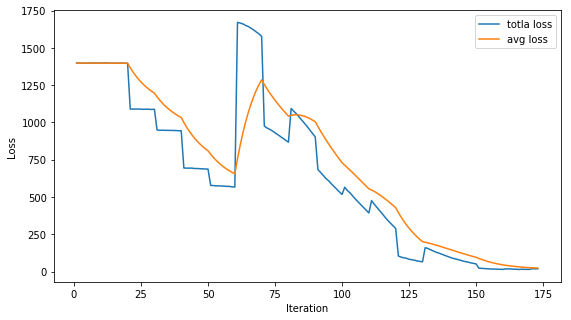

In [58]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

## Test on one example

In [62]:
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_patient_id = annots[annots.Target == 1].patientId.values[2]
shutil.copy(ex_img_path, "test.jpg")
print(ex_patient_id)

00704310-78a8-4b38-8475-49f4573b2dbb


In [66]:
!ls -alsth backup

total 471M
4.0K drwxr-xr-x 9 root root 4.0K Nov  2 00:53 ..
236M -rw-r--r-- 1 root root 235M Nov  2 00:25 rsna_yolov3_100.weights
4.0K drwxr-xr-x 2 root root 4.0K Nov  2 00:25 .
236M -rw-r--r-- 1 root root 235M Nov  2 00:25 rsna_yolov3.backup


In [68]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=10Yk6ZMAKGz5LeBbikciALy82aK3lX-57" -O cfg/rsna_yolov3.cfg_test

In [75]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_100.weights ../test.jpg -thresh 0.75

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Loading weights from ../backup/rsna_yolov3_100.weights...Done!
../test.jpg: Predicted in 0.190609 seconds.
pneumonia: 79%
pneumonia: 76%
pneumonia: 75%
pneumonia: 75%


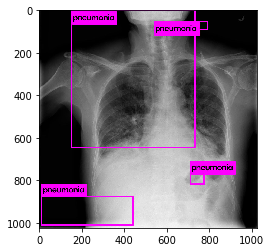

In [76]:
plt.imshow(cv2.imread("./darknet/predictions.jpg"))

### True label

0 0.3935546875 0.6142578125 0.15625 0.1015625

0 0.7578125 0.62841796875 0.158203125 0.1337890625



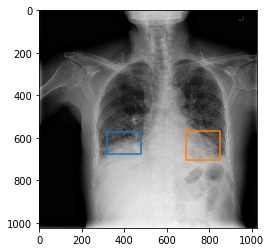

In [91]:
ex_patient_id = '00704310-78a8-4b38-8475-49f4573b2dbb'
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])